In [2]:
import numpy as np 
import pandas as pd 
import scanpy as sc
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import decoupler as dc
import gseapy as gp

In [2]:
DIR_WORKSPACE = '/node200data/18parkky/datasets'

In [3]:
def saveWithPickle(obj, PATH_out, filename="saveWithPickle"):
    import pickle
    with open(f'{PATH_out}/{filename}.pickle', 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def loadFromPickle(dir_pickle):
    import pickle
    with open(dir_pickle, 'rb') as handle:
        unserialized_pickle = pickle.load(handle)
    return unserialized_pickle

## Load data

In [4]:
dict_PatientID_to_MSI_class = {'SC044': 'MSI-H',
                                'P04': 'MSI-H',
                                'P21': 'MSI-H',
                                'P23': 'MSI-H',
                                'CRC2783': 'MSI-I',
                                'SC035': 'MSI-I',
                                'P15': 'MSI-I',
                                'P19': 'MSI-I',
                                'P20': 'MSI-I',
                                'P22': 'MSI-I',
                                'P26': 'MSI-I',
                                'CRC2817': 'MSI-L',
                                'P17': 'MSI-L',
                                'P18': 'MSI-L'}

In [20]:
adata_chen      = sc.read_h5ad(f'{DIR_WORKSPACE}/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.ManualAnnot.h5ad')
adata_joanito   = sc.read_h5ad(f'{DIR_WORKSPACE}/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.preprocessed.NanoMnT.ManualAnnot.h5ad')

adata_epi_chen      = adata_chen[adata_chen.obs['Manual_CellType_lvl_1']!='N/A'].copy()
adata_epi_joanito   = adata_joanito[adata_joanito.obs['Manual_CellType_lvl_1']!='N/A'].copy()

adata_epi_joanito   = adata_epi_joanito.raw.to_adata()
adata_epi_chen      = adata_epi_chen.raw.to_adata()

In [21]:
chen_patient_order_by_MSI_intensity     = ['P18', 'P17', 'P15', 'P26', 'P20', 'P19', 'P22', 'P23', 'P21', 'P04']
joanito_patient_order_by_MSI_intensity  = ['CRC2817', 'CRC2783', 'SC035', 'SC044']

In [22]:
joanito_patient_metadata = pd.read_csv(f'{DIR_WORKSPACE}/data/public/processed_data/Joanito_et_al/CRC-SG1/synapse-metadata/patient_clinical_information.csv', encoding='windows-1252')
# joanito_patient_metadata[joanito_patient_metadata['patient.ID'].isin(list(adata_joanito.obs['PatientID'])) & ~(joanito_patient_metadata['patient.ID'].isin(joanito_patient_order_by_MSI_intensity))]

In [23]:
joanito_tumor_DEG_summary   = pd.read_csv(f'{DIR_WORKSPACE}/data/public/processed_data/Joanito_et_al/3_DEG_identification/ScanpyRankGenesGroups.summary.tsv', sep='\t')
chen_tumor_DEG_summary      = pd.read_csv(f'{DIR_WORKSPACE}/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/3_DEG_identification/ScanpyRankGenesGroups.summary.tsv', sep='\t')

joanito_tumor_DEG_summary   = joanito_tumor_DEG_summary[joanito_tumor_DEG_summary['MSI_class']=='MSI-H'].copy()
chen_tumor_DEG_summary      = chen_tumor_DEG_summary[chen_tumor_DEG_summary['MSI_class']=='MSI-H'].copy()

In [24]:
adata_epi_joanito_tumor_DEGs = sc.read_h5ad(f'{DIR_WORKSPACE}/data/public/processed_data/Joanito_et_al/3_DEG_identification/Joanito.preprocessed.NanoMnT.ManualAnnot.Epi.DEGs.h5ad')
adata_epi_chen_tumor_DEGs    = sc.read_h5ad(f'{DIR_WORKSPACE}/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/3_DEG_identification/Chen.preprocessed.NanoMnT.ManualAnnot.Epi.DEGs.h5ad')

In [8]:
intersecting_up     = set(pd.read_csv(f'{DIR_WORKSPACE}/data/public/processed_data/CRC_MSI_intensity_analysis/DEGs/intersecting_up.txt', header=None,)[0])
intersecting_down   = set(pd.read_csv(f'{DIR_WORKSPACE}/data/public/processed_data/CRC_MSI_intensity_analysis/DEGs/intersecting_down.txt', header=None,)[0])

## EnrichR through GSEApy

In [649]:
EnrichR_intersecting_up = gp.enrichr(gene_list=list(intersecting_up), # or "./tests/data/gene_list.txt",
                                    gene_sets=['MSigDB_Hallmark_2020','KEGG_2021_Human', 
                                               'GO_Biological_Process_2023', 'GO_Cellular_Component_2023', 'GO_Molecular_Function_2023', 
                                               'CellMarker_2024'],
                                    # gene_sets=['CellMarker_2024'],
                                    organism='human', 
                                    # background="/node200data/18parkky/datasets/data/public/processed_data/CRC_MSI_intensity_analysis/DEGs/BackgroundGenes.txt",
                                    outdir=None, 
                                    )

EnrichR_intersecting_dw = gp.enrichr(gene_list=list(intersecting_down), # or "./tests/data/gene_list.txt",
                                    gene_sets=['MSigDB_Hallmark_2020','KEGG_2021_Human', 
                                               'GO_Biological_Process_2023', 'GO_Cellular_Component_2023', 'GO_Molecular_Function_2023', 
                                               'CellMarker_2024'],  
                                    # gene_sets=['CellMarker_2024'],                                  
                                    organism='human',
                                    # background="/node200data/18parkky/datasets/data/public/processed_data/CRC_MSI_intensity_analysis/DEGs/BackgroundGenes.txt", 
                                    outdir=None, 
                                    )

In [543]:
EnrichR_intersecting_up_CellMarkerResults = EnrichR_intersecting_up.results[(EnrichR_intersecting_up.results['Gene_set']=='CellMarker_2024')].copy()
EnrichR_intersecting_dw_CellMarkerResults = EnrichR_intersecting_dw.results[(EnrichR_intersecting_dw.results['Gene_set']=='CellMarker_2024')].copy()

EnrichR_intersecting_up_CellMarkerResults['Organism'] = [ Term.split(' ')[-1] for Term in EnrichR_intersecting_up_CellMarkerResults['Term'] ]
EnrichR_intersecting_dw_CellMarkerResults['Organism'] = [ Term.split(' ')[-1] for Term in EnrichR_intersecting_dw_CellMarkerResults['Term'] ]

EnrichR_intersecting_up_CellMarkerResults = EnrichR_intersecting_up_CellMarkerResults[(EnrichR_intersecting_up_CellMarkerResults['Organism']=='Human')]
EnrichR_intersecting_dw_CellMarkerResults = EnrichR_intersecting_dw_CellMarkerResults[(EnrichR_intersecting_dw_CellMarkerResults['Organism']=='Human')]

# EnrichR_intersecting_up.results[(EnrichR_intersecting_up.results['Adjusted P-value']<=0.05) & (EnrichR_intersecting_up.results['Gene_set']=='CellMarker_2024')].sort_values('Combined Score', ascending=False,)

EnrichR_intersecting_up_CellMarkerResults['n_genes'] = [ len(Genes.split(';')) for Genes in EnrichR_intersecting_up_CellMarkerResults['Genes'] ]
EnrichR_intersecting_dw_CellMarkerResults['n_genes'] = [ len(Genes.split(';')) for Genes in EnrichR_intersecting_dw_CellMarkerResults['Genes'] ]

Gene_set                                        Term Overlap  \
2   CellMarker_2024                       Stem Cell Colon Human     3/6   
3   CellMarker_2024  Intestinal Stem Cell Small Intestine Human     3/8   
6   CellMarker_2024                   Stem Cell Intestine Human     3/9   
19  CellMarker_2024           Trophectoderm Cell Placenta Human     2/7   
20  CellMarker_2024           Mesenchymal Stem Cell Tooth Human     2/7   

     P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
2   0.000033          0.004485            0                     0   83.720339   
3   0.000090          0.007862            0                     0   50.227119   
6   0.000134          0.007862            0                     0   41.853814   
19  0.002870          0.052324            0                     0   33.343460   
20  0.002870          0.052324            0                     0   33.343460   

    Combined Score             Genes Organism  n_genes  
2       864.370200  SMOC2;EPHB2;RGMB    Human        3  
3       467.745704  CD24;EPHB2;ASCL2    Human        3  
6       373.169023  SMOC2;CD24;ASCL2    Human        3  
19      195.168269         SOX4;TBX3    Human        2  
20      195.168269         TFRC;CD24    Human        2

### Visualize ORA results (CellMarker_2024)

In [547]:
EnrichR_intersecting_up_CellMarkerResults['class'] = 'MSI-H'
EnrichR_intersecting_dw_CellMarkerResults['class'] = 'MSI-L'

In [551]:
EnrichR_CellMarkerResults = pd.concat([EnrichR_intersecting_up_CellMarkerResults.sort_values(['Combined Score', 'n_genes',], ascending=False,).head(6), 
                                       EnrichR_intersecting_dw_CellMarkerResults.sort_values(['Combined Score', 'n_genes',], ascending=False,).head(6)])
EnrichR_CellMarkerResults

Gene_set                                        Term Overlap  \
2   CellMarker_2024                       Stem Cell Colon Human     3/6   
3   CellMarker_2024  Intestinal Stem Cell Small Intestine Human     3/8   
6   CellMarker_2024                   Stem Cell Intestine Human     3/9   
19  CellMarker_2024           Trophectoderm Cell Placenta Human     2/7   
20  CellMarker_2024           Mesenchymal Stem Cell Tooth Human     2/7   
23  CellMarker_2024         Progenitor Cell Adrenal Gland Human     2/8   
2   CellMarker_2024                     Goblet Cell Colon Human     5/8   
6   CellMarker_2024        Memory T Cell Peripheral Blood Human     4/7   
0   CellMarker_2024                       Basal Cell Lung Human   13/99   
10  CellMarker_2024                       Monocyte Spleen Human    3/10   
5   CellMarker_2024           Goblet Cell Small Intestine Human    7/40   
8   CellMarker_2024                Goblet Cell Epithelium Human    4/17   

         P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
2   3.281927e-05      4.485300e-03            0                     0   
3   9.027836e-05      7.861616e-03            0                     0   
6   1.342227e-04      7.861616e-03            0                     0   
19  2.870498e-03      5.232448e-02            0                     0   
20  2.870498e-03      5.232448e-02            0                     0   
23  3.797242e-03      6.227477e-02            0                     0   
2   2.811397e-09      3.795387e-07            0                     0   
6   2.032616e-07      1.176014e-05            0                     0   
0   4.182551e-12      1.693933e-09            0                     0   
10  7.812338e-05      2.876361e-03            0                     0   
5   5.501271e-08      3.713358e-06            0                     0   
8   1.289674e-05      5.803534e-04            0                     0   

    Odds Ratio  Combined Score  \
2    83.720339      864.370200   
3    50.227119      467.745704   
6    41.853814      373.169023   
19   33.343460      195.168269   
20   33.343460      195.168269   
23   27.784810      154.858090   
2   192.054264     3781.468587   
6   152.755299     2353.771574   
0    18.192073      476.634132   
10   48.807882      461.586934   
5    24.693405      412.767584   
8    35.233437      396.676913   

                                                Genes Organism  n_genes  class  
2                                    SMOC2;EPHB2;RGMB    Human        3  MSI-H  
3                                    CD24;EPHB2;ASCL2    Human        3  MSI-H  
6                                    SMOC2;CD24;ASCL2    Human        3  MSI-H  
19                                          SOX4;TBX3    Human        2  MSI-H  
20                                          TFRC;CD24    Human        2  MSI-H  
23                                      BCL11A;POU6F2    Human        2  MSI-H  
2                         SPINK4;MUC2;FFAR4;TFF3;TFF1    Human        5  MSI-L  
6                        LGALS3;S100A6;S100A4;S100A10    Human        4  MSI-L  
0   IFI27L2;FGFBP1;GPX2;S100A2;AQP3;SERPINB5;S100A...    Human       13  MSI-L  
10                                  S100A6;S100A4;LYZ    Human        3  MSI-L  
5               SPINK4;MUC2;GSN;REP15;REG4;TFF1;BCAS1    Human        7  MSI-L  
8                              SPINK4;MUC2;TFF3;ATOH1    Human        4  MSI-L

In [556]:
sns.color_palette('icefire', 8)

[(0.42110294, 0.69916972, 0.80506683),
 (0.2157176, 0.47827123, 0.81487615),
 (0.2659204, 0.25949691, 0.511417),
 (0.14254381, 0.14016944, 0.18944326),
 (0.19884415, 0.12394381, 0.1385669),
 (0.47151732, 0.17401641, 0.24610337),
 (0.78979746, 0.24694858, 0.22678822),
 (0.93850535, 0.52748892, 0.28242464)]

In [565]:
EnrichR_CellMarkerResults

Gene_set                                        Term Overlap  \
2   CellMarker_2024                       Stem Cell Colon Human     3/6   
3   CellMarker_2024  Intestinal Stem Cell Small Intestine Human     3/8   
6   CellMarker_2024                   Stem Cell Intestine Human     3/9   
19  CellMarker_2024           Trophectoderm Cell Placenta Human     2/7   
20  CellMarker_2024           Mesenchymal Stem Cell Tooth Human     2/7   
23  CellMarker_2024         Progenitor Cell Adrenal Gland Human     2/8   
2   CellMarker_2024                     Goblet Cell Colon Human     5/8   
6   CellMarker_2024        Memory T Cell Peripheral Blood Human     4/7   
0   CellMarker_2024                       Basal Cell Lung Human   13/99   
10  CellMarker_2024                       Monocyte Spleen Human    3/10   
5   CellMarker_2024           Goblet Cell Small Intestine Human    7/40   
8   CellMarker_2024                Goblet Cell Epithelium Human    4/17   

         P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
2   3.281927e-05      4.485300e-03            0                     0   
3   9.027836e-05      7.861616e-03            0                     0   
6   1.342227e-04      7.861616e-03            0                     0   
19  2.870498e-03      5.232448e-02            0                     0   
20  2.870498e-03      5.232448e-02            0                     0   
23  3.797242e-03      6.227477e-02            0                     0   
2   2.811397e-09      3.795387e-07            0                     0   
6   2.032616e-07      1.176014e-05            0                     0   
0   4.182551e-12      1.693933e-09            0                     0   
10  7.812338e-05      2.876361e-03            0                     0   
5   5.501271e-08      3.713358e-06            0                     0   
8   1.289674e-05      5.803534e-04            0                     0   

    Odds Ratio  Combined Score  \
2    83.720339      864.370200   
3    50.227119      467.745704   
6    41.853814      373.169023   
19   33.343460      195.168269   
20   33.343460      195.168269   
23   27.784810      154.858090   
2   192.054264     3781.468587   
6   152.755299     2353.771574   
0    18.192073      476.634132   
10   48.807882      461.586934   
5    24.693405      412.767584   
8    35.233437      396.676913   

                                                Genes Organism  n_genes  class  
2                                    SMOC2;EPHB2;RGMB    Human        3  MSI-H  
3                                    CD24;EPHB2;ASCL2    Human        3  MSI-H  
6                                    SMOC2;CD24;ASCL2    Human        3  MSI-H  
19                                          SOX4;TBX3    Human        2  MSI-H  
20                                          TFRC;CD24    Human        2  MSI-H  
23                                      BCL11A;POU6F2    Human        2  MSI-H  
2                         SPINK4;MUC2;FFAR4;TFF3;TFF1    Human        5  MSI-L  
6                        LGALS3;S100A6;S100A4;S100A10    Human        4  MSI-L  
0   IFI27L2;FGFBP1;GPX2;S100A2;AQP3;SERPINB5;S100A...    Human       13  MSI-L  
10                                  S100A6;S100A4;LYZ    Human        3  MSI-L  
5               SPINK4;MUC2;GSN;REP15;REG4;TFF1;BCAS1    Human        7  MSI-L  
8                              SPINK4;MUC2;TFF3;ATOH1    Human        4  MSI-L

In [1]:
plt.figure(figsize=(6, 3.5), dpi=400)
ax = sns.barplot(data=EnrichR_CellMarkerResults, y='Term', x='Combined Score', hue='class', palette={'MSI-H' : sns.color_palette('icefire', 8)[-1], 'MSI-L':sns.color_palette('icefire', 8)[0]}, legend=None,)
ax.set_xlabel('');
ax.set_ylabel('');
# ax.set_xticklabels([]);
# ax.set_yticklabels([]);

NameError: name 'plt' is not defined

In [546]:
EnrichR_intersecting_dw_CellMarkerResults.sort_values(['Combined Score', 'n_genes',], ascending=False,).head(5)

Gene_set                                  Term Overlap  \
2   CellMarker_2024               Goblet Cell Colon Human     5/8   
6   CellMarker_2024  Memory T Cell Peripheral Blood Human     4/7   
0   CellMarker_2024                 Basal Cell Lung Human   13/99   
10  CellMarker_2024                 Monocyte Spleen Human    3/10   
5   CellMarker_2024     Goblet Cell Small Intestine Human    7/40   

         P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
2   2.811397e-09      3.795387e-07            0                     0   
6   2.032616e-07      1.176014e-05            0                     0   
0   4.182551e-12      1.693933e-09            0                     0   
10  7.812338e-05      2.876361e-03            0                     0   
5   5.501271e-08      3.713358e-06            0                     0   

    Odds Ratio  Combined Score  \
2   192.054264     3781.468587   
6   152.755299     2353.771574   
0    18.192073      476.634132   
10   48.807882      461.586934   
5    24.693405      412.767584   

                                                Genes Organism  n_genes  
2                         SPINK4;MUC2;FFAR4;TFF3;TFF1    Human        5  
6                        LGALS3;S100A6;S100A4;S100A10    Human        4  
0   IFI27L2;FGFBP1;GPX2;S100A2;AQP3;SERPINB5;S100A...    Human       13  
10                                  S100A6;S100A4;LYZ    Human        3  
5               SPINK4;MUC2;GSN;REP15;REG4;TFF1;BCAS1    Human        7

In [523]:
EnrichR_intersecting_dw.results[(EnrichR_intersecting_dw.results['Adjusted P-value']<=0.05) & 
                                (EnrichR_intersecting_dw.results['Gene_set']=='CellMarker_2024')].sort_values('Combined Score', ascending=False,)

Gene_set                                               Term  \
1425  CellMarker_2024               Hematopoietic Stem Cell Embryo Human   
1414  CellMarker_2024                            Goblet Cell Colon Human   
1417  CellMarker_2024               Memory T Cell Peripheral Blood Human   
1422  CellMarker_2024                              Monocyte Spleen Human   
1435  CellMarker_2024                            Pericyte Synovium Human   
1436  CellMarker_2024      Deep Crypt Secretory Cell Colonic Crypt Mouse   
1437  CellMarker_2024                       Endothelial Cell Heart Human   
1438  CellMarker_2024                            Goblet Cell Colon Mouse   
1411  CellMarker_2024                              Basal Cell Lung Human   
1416  CellMarker_2024                  Goblet Cell Small Intestine Human   
1442  CellMarker_2024                         Immune Cell Bronchus Human   
1412  CellMarker_2024                  Goblet Cell Small Intestine Mouse   
1420  CellMarker_2024                       Goblet Cell Epithelium Human   
1421  CellMarker_2024                       Macrophage Bone Marrow Mouse   
1445  CellMarker_2024                  Neutrophil Peripheral Blood Human   
1427  CellMarker_2024                         Luminal Cell Bladder Human   
1419  CellMarker_2024                  Goblet Cell Large Intestine Human   
1448  CellMarker_2024  Conventional Dendritic Cell 2b(cDC2b) Brain Human   
1431  CellMarker_2024                 Basal Cell Airway Epithelium Human   
1430  CellMarker_2024  Myeloid-derived Suppressor Cell Peripheral Blo...   
1415  CellMarker_2024                        Krt4/13+ Cell Trachea Mouse   
1418  CellMarker_2024                           Basal Cell Trachea Mouse   
1454  CellMarker_2024                  Enterocyte Intestinal Crypt Mouse   
1453  CellMarker_2024                    Progenitor Cell Undefined Human   
1456  CellMarker_2024                             Stem Cell Embryo Mouse   
1455  CellMarker_2024                             Eosinophil Blood Human   
1413  CellMarker_2024                 Goblet Cell Intestinal Crypt Mouse   
1439  CellMarker_2024                 CD4+ T Cell Peripheral Blood Human   
1458  CellMarker_2024                     Cancer Stem Cell Thyroid Human   
1459  CellMarker_2024           Endothelial Stem Cell Blood Vessel Human   
1457  CellMarker_2024              Natural Killer Cell Bone Marrow Human   
1443  CellMarker_2024                               Mast Cell Lung Human   
1423  CellMarker_2024        Enteroendocrine Cell Intestinal Crypt Mouse   
1447  CellMarker_2024                       Type I Pneumocyte Lung Mouse   
1428  CellMarker_2024                             Macrophage Brain Human   
1449  CellMarker_2024                Endothelial Cell Blood Vessel Human   
1424  CellMarker_2024      Schwalie Et al.Nature.G1 Adipose Tissue Mouse   
1434  CellMarker_2024  Transit Amplifying (TA) Cell Intestinal Crypt ...   
1432  CellMarker_2024      Schwalie Et al.Nature.P1 Adipose Tissue Mouse   
1451  CellMarker_2024                   Enterocyte Small Intestine Mouse   
1426  CellMarker_2024                              Podocyte Kidney Mouse   
1452  CellMarker_2024                        Endothelial Cell Lung Mouse   
1429  CellMarker_2024                         Epithelial Cell Lung Mouse   
1440  CellMarker_2024             CD1C-CD141- Dendritic Cell Blood Human   
1433  CellMarker_2024                        Monocyte Fetal Kidney Human   
1441  CellMarker_2024          Hematopoietic Stem Cell Bone Marrow Mouse   
1444  CellMarker_2024                        Oligodendrocyte Brain Mouse   
1450  CellMarker_2024                 Paneth Cell Intestinal Crypt Mouse   
1446  CellMarker_2024          Mitotic Fetal Germ Cell Fetal Gonad Human   

           P-value  Adjusted P-value  Old P-value  Old adjusted P-value  \
1425  1.648489e-04      4.450919e-03            0                     0   
1414  6.877576e-09      6.963546e-07            0             

## GSEApy

In [56]:
gp.get_library_name()

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_2024',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DGIdb_Drug_Targets_2024',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_CRISPR_GeneDependency_CellLines_2023',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_Cell

In [313]:
gsea_pval_threshold = 1
gsea_qval_threshold = 0.25

In [405]:
def get_GSEA_results( adata, gene_sets, min_size=15 ):
    result = adata.uns['rank_genes_groups']
    # result = adata_epi_chen_tumor_DEGs.uns['rank_genes_groups']

    groups = result['names'].dtype.names
    degs = pd.DataFrame(
        {group + '_' + key: result[key][group]
        for group in groups for key in ['names','scores', 'pvals','pvals_adj','logfoldchanges']})
    
    pre_res = gp.prerank(degs.loc[:,['MSI-H_names', 'MSI-H_logfoldchanges']], gene_sets=gene_sets, min_size=min_size)
    return pre_res

def get_GSEA_results2( adata, geneoi, gene_sets, min_size=15 ):
    result = adata.uns['rank_genes_groups']
    # result = adata_epi_chen_tumor_DEGs.uns['rank_genes_groups']

    groups = result['names'].dtype.names
    degs = pd.DataFrame(
        {group + '_' + key: result[key][group]
        for group in groups for key in ['names','scores', 'pvals','pvals_adj','logfoldchanges']})
    
    degs = degs[degs['MSI-H_names'].isin(geneoi)].copy()
    degs.reset_index(inplace=True, drop=True)

    pre_res = gp.prerank(degs.loc[:,['MSI-H_names', 'MSI-H_logfoldchanges']], gene_sets=gene_sets, min_size=min_size)
    return pre_res


def draw_term_scatter( res2d1, res2d2, plot=True):
    
    intersecting_terms = set(res2d1['Term']).intersection(set(res2d2['Term']))
    print(f'Original lengths: {len(res2d1)}, {len(res2d2)}')
    print(f'Intersecting terms: {len(intersecting_terms)}')
    
    dict_TermNESComparisons = dict()
    for tup in res2d1[res2d1['Term'].isin(intersecting_terms)].itertuples():
        dict_TermNESComparisons[tup.Term] = [tup.NES]
    for tup in res2d2[res2d2['Term'].isin(intersecting_terms)].itertuples():
        dict_TermNESComparisons[tup.Term].append(tup.NES)

    if len(dict_TermNESComparisons) == 0:
        print(f'No intersections!')
        return 
    
    TermNESComparisons = pd.DataFrame.from_dict(dict_TermNESComparisons, orient='index')
    TermNESComparisons.reset_index(inplace=True)
    TermNESComparisons.columns = ['Term', '1', '2']
    if plot == True:
        sns.scatterplot(data=TermNESComparisons, x='1', y='2')
    else:
        return TermNESComparisons

### CellMarker 2024

In [101]:
Joanito_GSEA_CellMarker_out = get_GSEA_results( adata_epi_joanito_tumor_DEGs, 'CellMarker_2024' )
Chen_GSEA_CellMarker_out = get_GSEA_results( adata_epi_chen_tumor_DEGs, 'CellMarker_2024' )

2025-02-25 19:54:29,932 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [116]:
Joanito_GSEA_CellMarker_out.res2d['organism'] = [ t.split(' ')[-1] for t in Joanito_GSEA_CellMarker_out.res2d['Term'] ]
Chen_GSEA_CellMarker_out.res2d['organism'] = [ t.split(' ')[-1] for t in Chen_GSEA_CellMarker_out.res2d['Term'] ]

In [427]:
len(Joanito_GSEA_CellMarker_out.gmt['Goblet Cell Large Intestine Human'])

goblet_li = set(Joanito_GSEA_CellMarker_out.gmt['Goblet Cell Large Intestine Human'])
goblet_si = set(Joanito_GSEA_CellMarker_out.gmt['Goblet Cell Small Intestine Human'])

In [1625]:
for ct in Joanito_GSEA_CellMarker_out.gmt.keys():
    if 'ENTERO' in ct.upper():
        print(ct)

Enterocyte Progenitor Cell Small Intestine Human
Enterocyte Large Intestine Human
Enterocyte Small Intestine Mouse
Enteroendocrine Cell Intestinal Crypt Mouse
Enteroendocrine Cell Small Intestine Mouse
Enteroendocrine Precursor Cell Intestinal Crypt Mouse


In [445]:
import itertools

# Store sets in a list
gene_sets = {"goblet_li": goblet_li, "goblet_si": goblet_si, "metaplasia_signature": metaplasia_signature, "fetal_signature": fetal_signature}
for g, s in gene_sets.items():
    print(g, len(s))

# Compute intersections
for i in range(2, 3, ):  # 1-set to 4-set intersections
    for comb in itertools.combinations(gene_sets.keys(), i):
        intersected_genes = set.intersection(*(gene_sets[name] for name in comb))
        print(f"Intersection of {', '.join(comb)}: {len(intersected_genes)}")


goblet_li 36
goblet_si 31
metaplasia_signature 18
fetal_signature 57
Intersection of goblet_li, goblet_si: 3
Intersection of goblet_li, metaplasia_signature: 0
Intersection of goblet_li, fetal_signature: 0
Intersection of goblet_si, metaplasia_signature: 1
Intersection of goblet_si, fetal_signature: 1
Intersection of metaplasia_signature, fetal_signature: 5


In [ ]:
# Store sets in a dictionary
gene_sets = {"goblet_li": goblet_li, "goblet_si": goblet_si, "metaplasia_signature": metaplasia_signature, "fetal_signature": fetal_signature}

# Generate intersection matrix
all_genes = sorted(set.union(*gene_sets.values()))
data = {name: [gene in genes for gene in all_genes] for name, genes in gene_sets.items()}

# Convert to DataFrame
df = pd.DataFrame(data, index=all_genes)

# Plot heatmap
plt.figure(figsize=(8, len(df) * 0.3))  # Adjust figure size
sns.heatmap(df.astype(int), cmap="Blues", cbar=False, linewidths=0.5, linecolor="gray")

# Formatting
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.xlabel("Gene Sets")
plt.ylabel("Genes")
plt.title("Gene Presence Across Sets")
plt.show()


In [418]:
len(metaplasia_signature), len(fetal_signature), len(metaplasia_signature.intersection(fetal_signature))

(18, 57, 5)

In [429]:
len(goblet_si.intersection(metaplasia_signature))

1

In [315]:
Joanito_GSEA_CellMarker_out_significant = Joanito_GSEA_CellMarker_out.res2d[(Joanito_GSEA_CellMarker_out.res2d['NOM p-val']<=gsea_pval_threshold) & 
                                                                            (Joanito_GSEA_CellMarker_out.res2d['FDR q-val']<=gsea_qval_threshold) & 
                                                                            (Joanito_GSEA_CellMarker_out.res2d['organism']=='Human')]
Chen_GSEA_CellMarker_out_significant = Chen_GSEA_CellMarker_out.res2d[(Chen_GSEA_CellMarker_out.res2d['NOM p-val']<=gsea_pval_threshold) & 
                                                                      (Chen_GSEA_CellMarker_out.res2d['FDR q-val']<=gsea_qval_threshold) & 
                                                                      (Chen_GSEA_CellMarker_out.res2d['organism']=='Human')]

In [694]:
set(Joanito_GSEA_CellMarker_out_significant['Term']).intersection( set(Chen_GSEA_CellMarker_out_significant['Term']) )

{'Goblet Cell Large Intestine Human', 'Goblet Cell Small Intestine Human'}

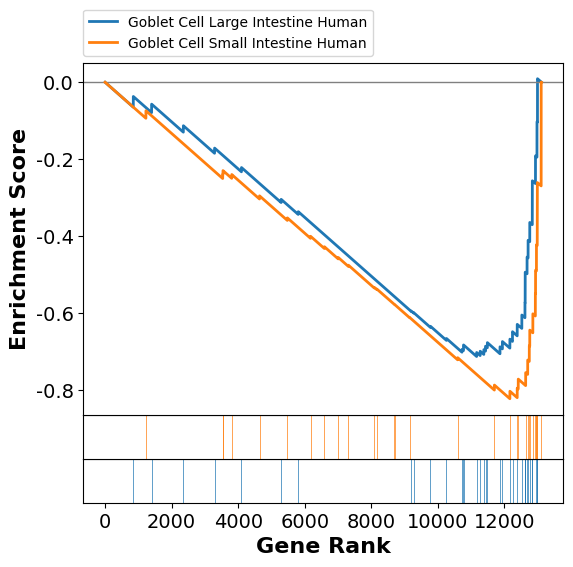

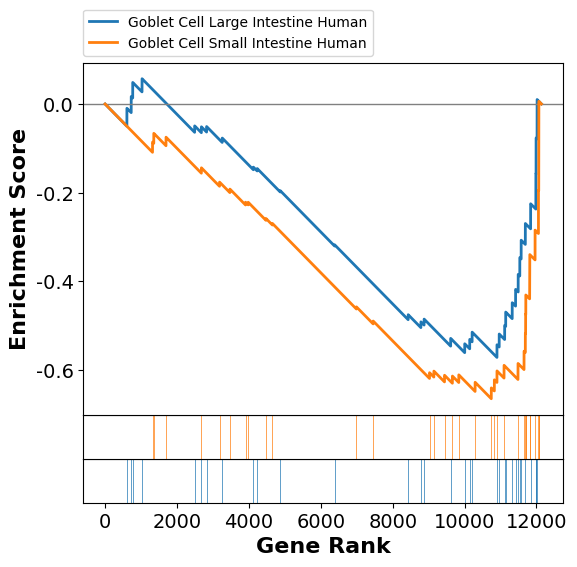

In [316]:
Term_oi = set(Joanito_GSEA_CellMarker_out_significant['Term']).intersection( set(Chen_GSEA_CellMarker_out_significant['Term']) )

term2 = Joanito_GSEA_CellMarker_out.res2d.Term
ax = Joanito_GSEA_CellMarker_out.plot(terms=Term_oi, show_ranking=False, )
ax = Chen_GSEA_CellMarker_out.plot(terms=Term_oi, show_ranking=False, )

### MSigDB_Oncogenic_Signatures

In [169]:
Joanito_GSEA_MsigDBOnco_out = get_GSEA_results( adata_epi_joanito_tumor_DEGs, 'MSigDB_Oncogenic_Signatures' )
Chen_GSEA_MsigDBOnco_out = get_GSEA_results( adata_epi_chen_tumor_DEGs, 'MSigDB_Oncogenic_Signatures' )

2025-02-25 20:24:00,491 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-02-25 20:24:12,041 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [317]:
Joanito_GSEA_MsigDBOnco_out_significant = Joanito_GSEA_MsigDBOnco_out.res2d[(Joanito_GSEA_MsigDBOnco_out.res2d['NOM p-val']<=gsea_pval_threshold) & 
                                                                            (Joanito_GSEA_MsigDBOnco_out.res2d['FDR q-val']<=gsea_qval_threshold)]
Chen_GSEA_MsigDBOnco_out_significant = Chen_GSEA_MsigDBOnco_out.res2d[(Chen_GSEA_MsigDBOnco_out.res2d['NOM p-val']<=gsea_pval_threshold) & 
                                                                      (Chen_GSEA_MsigDBOnco_out.res2d['FDR q-val']<=gsea_qval_threshold)]

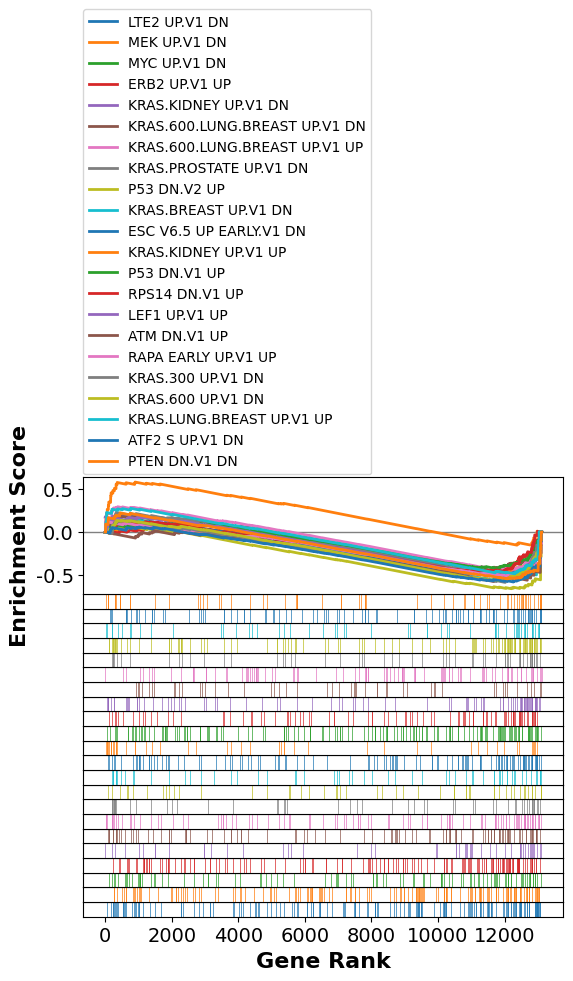

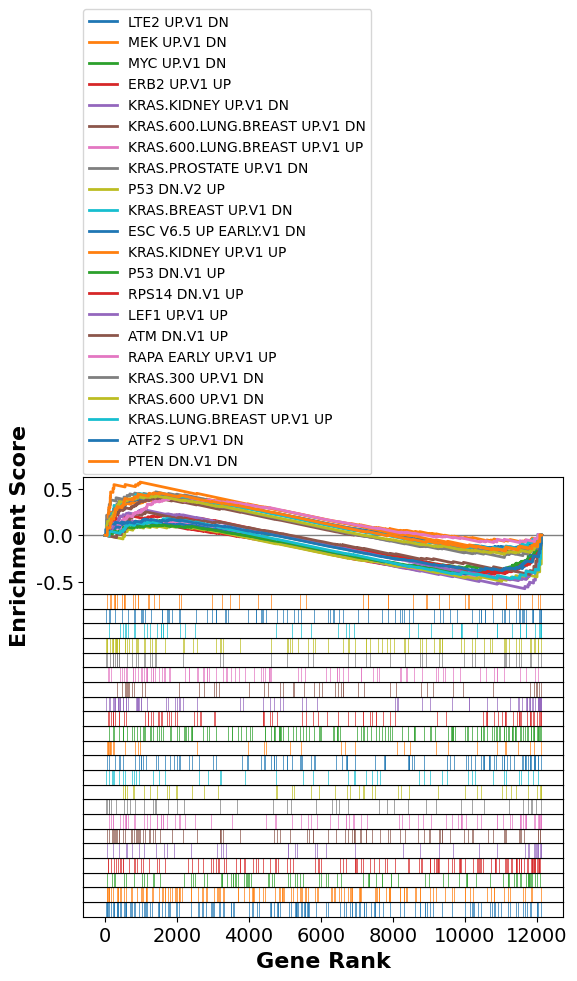

In [318]:
Term_oi = set(Joanito_GSEA_MsigDBOnco_out_significant['Term']).intersection(set(Chen_GSEA_MsigDBOnco_out_significant['Term']))

ax = Joanito_GSEA_MsigDBOnco_out.plot(terms=Term_oi, show_ranking=False, )
ax = Chen_GSEA_MsigDBOnco_out.plot(terms=Term_oi, show_ranking=False, )

### GO_Molecular_Function_2023

In [181]:
Joanito_GSEA_GO_Molecular_Function_2023_out = get_GSEA_results( adata_epi_joanito_tumor_DEGs, 'GO_Molecular_Function_2023' )
Chen_GSEA_GO_Molecular_Function_2023_out = get_GSEA_results( adata_epi_chen_tumor_DEGs, 'GO_Molecular_Function_2023' )

2025-02-25 20:28:58,194 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-02-25 20:29:12,804 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [319]:
Joanito_GSEA_GO_Molecular_Function_2023_out_significant = Joanito_GSEA_GO_Molecular_Function_2023_out.res2d[(Joanito_GSEA_GO_Molecular_Function_2023_out.res2d['NOM p-val']<=gsea_pval_threshold) & 
                                                                                            (Joanito_GSEA_GO_Molecular_Function_2023_out.res2d['FDR q-val']<=gsea_qval_threshold)]
Chen_GSEA_GO_Molecular_Function_2023_out_significant = Chen_GSEA_GO_Molecular_Function_2023_out.res2d[(Chen_GSEA_GO_Molecular_Function_2023_out.res2d['NOM p-val']<=gsea_pval_threshold) & 
                                                                                      (Chen_GSEA_GO_Molecular_Function_2023_out.res2d['FDR q-val']<=gsea_qval_threshold)]

In [320]:
draw_term_scatter(Joanito_GSEA_GO_Molecular_Function_2023_out_significant, Chen_GSEA_GO_Molecular_Function_2023_out_significant)

Original lengths: 3, 2
Intersecting terms: 0
No intersections!


### GO_Biological_Process_2021

In [206]:
Joanito_GSEA_GO_Biological_Process_2021_out = get_GSEA_results( adata_epi_joanito_tumor_DEGs, 'GO_Biological_Process_2021' )
Chen_GSEA_GO_Biological_Process_2021_out = get_GSEA_results( adata_epi_chen_tumor_DEGs, 'GO_Biological_Process_2021' )

2025-02-25 20:37:33,221 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-02-25 20:38:21,298 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [321]:
Joanito_GSEA_GO_Biological_Process_2021_out_significant = Joanito_GSEA_GO_Biological_Process_2021_out.res2d[(Joanito_GSEA_GO_Biological_Process_2021_out.res2d['NOM p-val']<=gsea_pval_threshold) & 
                                                                                            (Joanito_GSEA_GO_Biological_Process_2021_out.res2d['FDR q-val']<=gsea_qval_threshold)]
Chen_GSEA_GO_Biological_Process_2021_out_significant = Chen_GSEA_GO_Biological_Process_2021_out.res2d[(Chen_GSEA_GO_Biological_Process_2021_out.res2d['NOM p-val']<=gsea_pval_threshold) & 
                                                                                      (Chen_GSEA_GO_Biological_Process_2021_out.res2d['FDR q-val']<=gsea_qval_threshold)]

In [322]:
draw_term_scatter(Joanito_GSEA_GO_Biological_Process_2021_out_significant, Chen_GSEA_GO_Biological_Process_2021_out_significant)

Original lengths: 2, 2
Intersecting terms: 0
No intersections!


### MSigDB_Hallmark_2020

In [396]:
for e in intersecting_up.union(intersecting_down):
    try:
        float(e)
        print(e)
    except ValueError:
        pass 

In [415]:
Joanito_GSEA_MSigDB_Hallmark_2020_out = get_GSEA_results( adata_epi_joanito_tumor_DEGs, 'MSigDB_Hallmark_2020' )
Chen_GSEA_MSigDB_Hallmark_2020_out = get_GSEA_results( adata_epi_chen_tumor_DEGs, 'MSigDB_Hallmark_2020' )

2025-02-25 22:24:01,403 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-02-25 22:24:02,853 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [412]:
Joanito_GSEA_MSigDB_Hallmark_2020_out_significant = Joanito_GSEA_MSigDB_Hallmark_2020_out.res2d[(Joanito_GSEA_MSigDB_Hallmark_2020_out.res2d['NOM p-val']<=gsea_pval_threshold) & 
                                                                                            (Joanito_GSEA_MSigDB_Hallmark_2020_out.res2d['FDR q-val']<=gsea_qval_threshold)]
Chen_GSEA_MSigDB_Hallmark_2020_out_significant = Chen_GSEA_MSigDB_Hallmark_2020_out.res2d[(Chen_GSEA_MSigDB_Hallmark_2020_out.res2d['NOM p-val']<=gsea_pval_threshold) & 
                                                                                      (Chen_GSEA_MSigDB_Hallmark_2020_out.res2d['FDR q-val']<=gsea_qval_threshold)]

In [413]:
draw_term_scatter(Joanito_GSEA_MSigDB_Hallmark_2020_out_significant, Chen_GSEA_MSigDB_Hallmark_2020_out_significant, plot=False,)

Original lengths: 0, 1
Intersecting terms: 0
No intersections!


### Reactome_Pathways_2024

In [471]:
Joanito_GSEA_MSigDB_Hallmark_2020_out = get_GSEA_results( adata_epi_joanito_tumor_DEGs, 'Reactome_Pathways_2024' )
Chen_GSEA_MSigDB_Hallmark_2020_out = get_GSEA_results( adata_epi_chen_tumor_DEGs, 'Reactome_Pathways_2024' )

2025-02-25 23:25:13,792 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-02-25 23:25:46,406 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [480]:
Joanito_GSEA_MSigDB_Hallmark_2020_out_significant = Joanito_GSEA_MSigDB_Hallmark_2020_out.res2d[(Joanito_GSEA_MSigDB_Hallmark_2020_out.res2d['NOM p-val']<=gsea_pval_threshold) & 
                                                                                            (Joanito_GSEA_MSigDB_Hallmark_2020_out.res2d['FDR q-val']<=gsea_qval_threshold)]
Chen_GSEA_MSigDB_Hallmark_2020_out_significant = Chen_GSEA_MSigDB_Hallmark_2020_out.res2d[(Chen_GSEA_MSigDB_Hallmark_2020_out.res2d['NOM p-val']<=gsea_pval_threshold) & 
                                                                                      (Chen_GSEA_MSigDB_Hallmark_2020_out.res2d['FDR q-val']<=gsea_qval_threshold)]

In [481]:
draw_term_scatter(Joanito_GSEA_MSigDB_Hallmark_2020_out_significant, Chen_GSEA_MSigDB_Hallmark_2020_out_significant, plot=False,)

Original lengths: 12, 68
Intersecting terms: 1


Term         1         2
0  Orc1 Removal From Chromatin  1.870115 -1.625755

In [ ]:
Term_oi = ['']

ax = Joanito_GSEA_MsigDBOnco_out.plot(terms=Term_oi, show_ranking=False, )
ax = Chen_GSEA_MsigDBOnco_out.plot(terms=Term_oi, show_ranking=False, )

### Custom1. Chen et al., Fetal/Metaplasia/Stem

In [2]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(set(list1)) + len(set(list2))) - intersection
    return float(intersection) / union

In [337]:
fetal_signature         = set(pd.read_csv('/node200data/18parkky/datasets/reference/marker_genes/colon/Chen_et_al/fetal_signature.txt', header=None,)[0])
metaplasia_signature    = set(pd.read_csv('/node200data/18parkky/datasets/reference/marker_genes/colon/Chen_et_al/metaplasia_signature.txt', header=None)[0])
stem_signature          = set(pd.read_csv('/node200data/18parkky/datasets/reference/marker_genes/colon/Chen_et_al/wnt_stem_signature.txt', header=None)[0])

In [9]:
coef = 1000
coef*jaccard_similarity( fetal_signature, intersecting_up ), coef*jaccard_similarity( metaplasia_signature, intersecting_up ), coef*jaccard_similarity( stem_signature, intersecting_up )

(0.0, 0.0, 8.064516129032258)

In [10]:
coef*jaccard_similarity( fetal_signature, intersecting_down ), coef*jaccard_similarity( metaplasia_signature, intersecting_down ), coef*jaccard_similarity( stem_signature, intersecting_down )

(35.39823008849557, 20.942408376963353, 5.347593582887701)

In [338]:
KenLau_geneset = {
          "Metaplasia_signature": list(metaplasia_signature),
          "Fetal_signature": list(fetal_signature),
          "Wnt_Stem_signature": list(stem_signature)
         }

In [339]:
Joanito_KenLau_out  = get_GSEA_results( adata_epi_joanito_tumor_DEGs, KenLau_geneset, 1 )
Chen_KenLau_out     = get_GSEA_results( adata_epi_chen_tumor_DEGs, KenLau_geneset, 1 )

2025-02-25 22:03:24,542 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-02-25 22:03:25,037 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [340]:
Joanito_GSEA_KenLau_out_significant = Joanito_KenLau_out.res2d[(Joanito_KenLau_out.res2d['NOM p-val']<=1) & 
                                                                             (Joanito_KenLau_out.res2d['FDR q-val']<=gsea_qval_threshold)]
Chen_GSEA_KenLau_out_significant = Chen_KenLau_out.res2d[(Chen_KenLau_out.res2d['NOM p-val']<=1) & 
                                                                       (Chen_KenLau_out.res2d['FDR q-val']<=gsea_qval_threshold)]

In [341]:
Joanito_GSEA_KenLau_out_significant

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank       Fetal_signature -0.745548 -2.016112       0.0       0.0   
1  prerank  Metaplasia_signature  -0.87256 -2.004047       0.0       0.0   
2  prerank    Wnt_Stem_signature  0.557839  1.229988  0.225303  0.207174   

  FWER p-val  Tag %  Gene %                                         Lead_genes  
0        0.0  28/51  11.10%  VSIG1;CD55;ANXA1;MSLN;HYAL1;VNN1;KIFC3;CLIC3;P...  
1        0.0  13/17  10.42%  ANXA10;TFF2;ANXA1;MSLN;MUC5AC;REG4;MUC17;IL18;...  
2      0.295   5/10  11.10%                        ASCL2;LGR5;TEAD2;EPHB2;CD44

In [342]:
Chen_GSEA_KenLau_out_significant

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank       Fetal_signature -0.549309 -1.754629  0.001938   0.01027   
1  prerank  Metaplasia_signature -0.672324 -1.635143  0.021073  0.019255   
2  prerank    Wnt_Stem_signature  0.592617  1.390716  0.129167  0.112344   

  FWER p-val  Tag %  Gene %                                         Lead_genes  
0   0.009029  13/44  11.31%  SERPINB5;S100A4;GJB3;CLIC3;S100A11;S100A14;GSN...  
1   0.032731   5/14   3.30%                         ANXA10;REG4;S100P;IL18;MDK  
2      0.151   6/11  13.58%                 OLFM4;ASCL2;EPHB2;TEAD2;TGFBI;CDX2

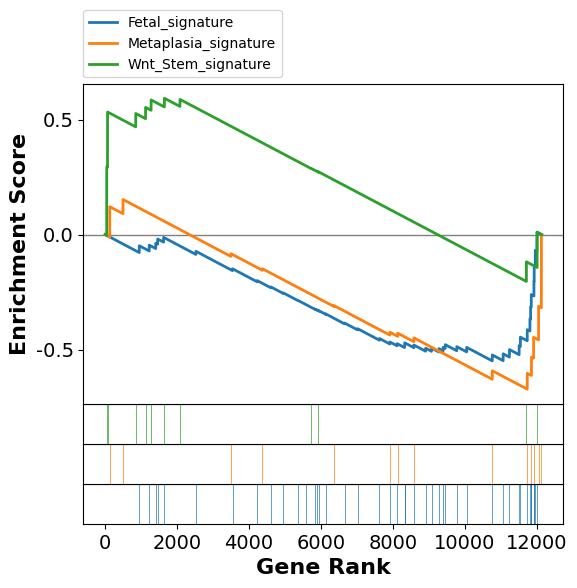

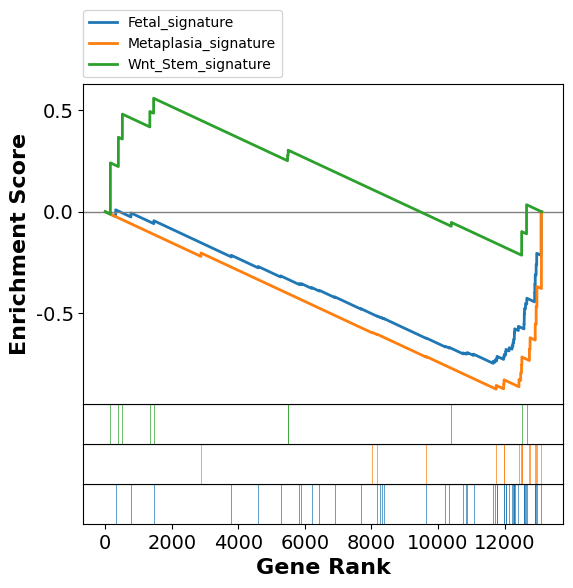

In [344]:
ax = Chen_KenLau_out.plot(terms=['Fetal_signature', 'Metaplasia_signature', 'Wnt_Stem_signature'], show_ranking=False, )
ax = Joanito_KenLau_out.plot(terms=['Fetal_signature', 'Metaplasia_signature', 'Wnt_Stem_signature'], show_ranking=False, )

### Custom2. Joanito et al., various genesets

In [359]:
KosinskiCryptBottom_signature   = set(pd.read_csv('/node200data/18parkky/datasets/reference/marker_genes/colon/Joanito_et_al/KosinskiCryptBottom.S9.txt', header=None,)[0])
KosinskiCryptTop_signature      = set(pd.read_csv('/node200data/18parkky/datasets/reference/marker_genes/colon/Joanito_et_al/KosinskiCryptTop.S9.txt', header=None)[0])
GastricMetaplasia_signature     = set(pd.read_csv('/node200data/18parkky/datasets/reference/marker_genes/colon/Joanito_et_al/GastricMetaplasia.S9.txt', header=None)[0])

iCMS2_up = set(pd.read_csv('/node200data/18parkky/datasets/reference/marker_genes/colon/iCMS_marker/iCMS_marker_genes.csv',)['iCMS2_Up'].dropna())
iCMS3_up = set(pd.read_csv('/node200data/18parkky/datasets/reference/marker_genes/colon/iCMS_marker/iCMS_marker_genes.csv',)['iCMS3_Up'].dropna())

iCMS2_dw = set(pd.read_csv('/node200data/18parkky/datasets/reference/marker_genes/colon/iCMS_marker/iCMS_marker_genes.csv',)['iCMS2_Down'].dropna())
iCMS3_dw = set(pd.read_csv('/node200data/18parkky/datasets/reference/marker_genes/colon/iCMS_marker/iCMS_marker_genes.csv',)['iCMS3_Down'].dropna())

In [360]:
IainTan_geneset = {
          "KosinskiCryptTop_signature": list(KosinskiCryptTop_signature),
          "KosinskiCryptBottom_signature": list(KosinskiCryptBottom_signature),
          "GastricMetaplasia_signature": list(GastricMetaplasia_signature),
          
          "iCMS2_up": list(iCMS2_up),
          "iCMS3_up": list(iCMS3_up),
         }

In [361]:
Joanito_IainTan_out  = get_GSEA_results( adata_epi_joanito_tumor_DEGs, IainTan_geneset, 1 )
Chen_IainTan_out     = get_GSEA_results( adata_epi_chen_tumor_DEGs, IainTan_geneset, 1 )

2025-02-25 22:09:25,519 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-02-25 22:09:26,110 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [366]:
Joanito_GSEA_IainTan_out_significant = Joanito_IainTan_out.res2d[(Joanito_IainTan_out.res2d['NOM p-val']<=gsea_pval_threshold) & 
                                                                             (Joanito_IainTan_out.res2d['FDR q-val']<=gsea_qval_threshold)]
Chen_GSEA_IainTan_out_significant = Chen_IainTan_out.res2d[(Chen_IainTan_out.res2d['NOM p-val']<=gsea_pval_threshold) & 
                                                                       (Chen_IainTan_out.res2d['FDR q-val']<=gsea_qval_threshold)]

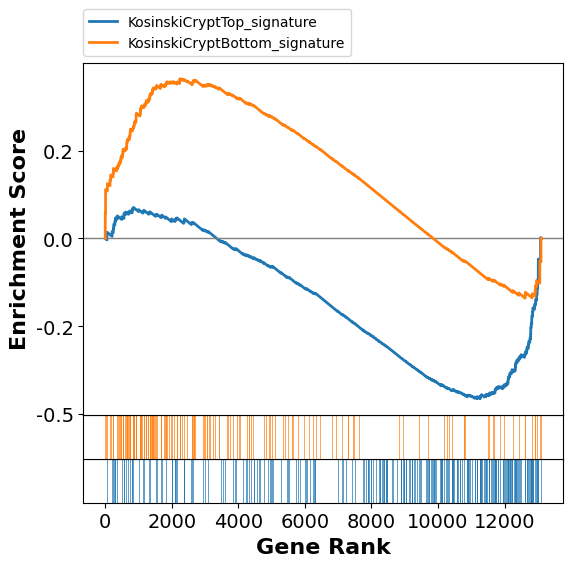

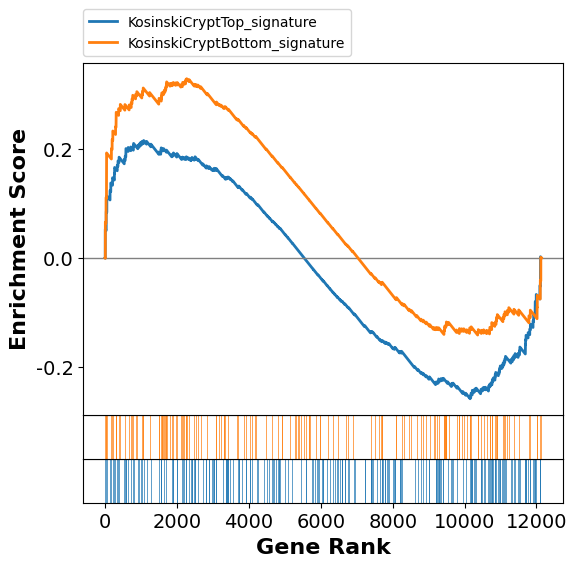

In [1365]:
ax = Joanito_IainTan_out.plot(terms=['KosinskiCryptTop_signature', 'KosinskiCryptBottom_signature'], show_ranking=False, )
ax = Chen_IainTan_out.plot(terms=['KosinskiCryptTop_signature', 'KosinskiCryptBottom_signature'], show_ranking=False, )

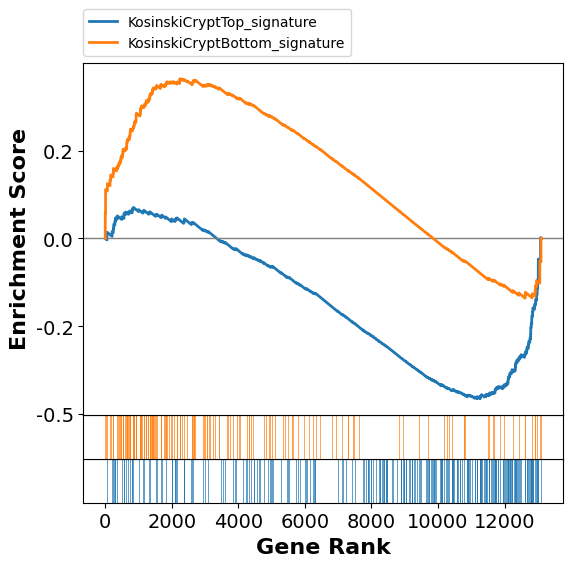

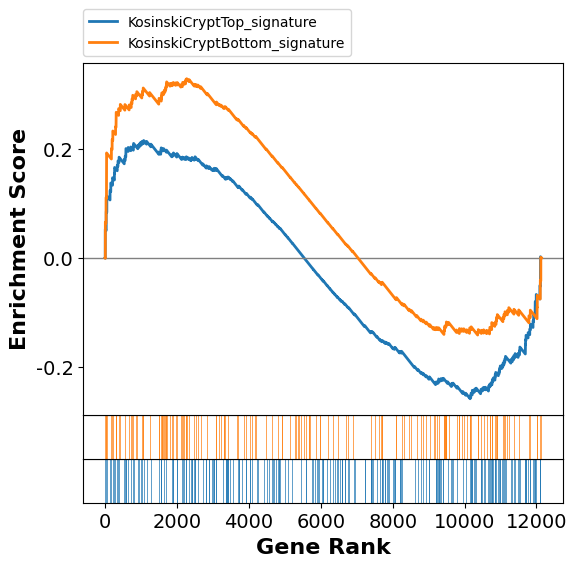

In [298]:
ax = Joanito_IainTan_out.plot(terms=['KosinskiCryptTop_signature', 'KosinskiCryptBottom_signature'], show_ranking=False, )
ax = Chen_IainTan_out.plot(terms=['KosinskiCryptTop_signature', 'KosinskiCryptBottom_signature'], show_ranking=False, )

In [295]:
Chen_IainTan_out.res2d

Name                           Term        ES       NES NOM p-val  \
0  prerank    GastricMetaplasia_signature -0.704176 -1.542779  0.043315   
1  prerank  KosinskiCryptBottom_signature  0.329284  1.292161  0.084016   
2  prerank     KosinskiCryptTop_signature -0.258497 -1.058973  0.302144   

  FDR q-val FWER p-val   Tag %  Gene %  \
0   0.03856   0.033822     5/9   5.39%   
1  0.103186      0.144  46/157  18.71%   
2  0.347044   0.508455  54/226  16.36%   

                                          Lead_genes  
0                          ANXA10;REG4;TFF3;MDK;MUC2  
1  SMOC2;TIMP3;STK33;OLFM4;FRAS1;GPC4;FN1;CLU;CDK...  
2  HSD17B2;CTSE;DEFB1;GCNT3;BDKRB2;TFF1;DST;ALOX5...

### Final visualization: KenLau + CellMarker + JoanitoCryptMarkers

In [ ]:
dict_celltype_to_genes = dict()
with open('/node200data/18parkky/datasets/reference/marker_genes/CellMarker_2024/CellMarker_2024.Goblet.tsv', 'r') as f:
    for line in f:
        dict_celltype_to_genes[line.split('\t')[0]] = [g.strip() for g in line.split('\t')[2:]]

pd.DataFrame.from_dict(dict_celltype_to_genes, orient='index').T.to_csv('/node200data/18parkky/datasets/data/public/processed_data/CRC_MSI_intensity_analysis/CellMarker_2024/SelectedCellTypes.tsv', sep='\t', index=False)

In [648]:
fetal_signature         = set(pd.read_csv('/node200data/18parkky/datasets/reference/marker_genes/colon/Chen_et_al/fetal_signature.txt', header=None,)[0])
metaplasia_signature    = set(pd.read_csv('/node200data/18parkky/datasets/reference/marker_genes/colon/Chen_et_al/metaplasia_signature.txt', header=None)[0])
stem_signature          = set(pd.read_csv('/node200data/18parkky/datasets/reference/marker_genes/colon/Chen_et_al/wnt_stem_signature.txt', header=None)[0])

large_intestine_goblet_markers = set(pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/CRC_MSI_intensity_analysis/CellMarker_2024/SelectedCellTypes.tsv', sep='\t', )['Goblet Cell Large Intestine Human'].dropna())
small_intestine_goblet_markers = set(pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/CRC_MSI_intensity_analysis/CellMarker_2024/SelectedCellTypes.tsv', sep='\t', )['Goblet Cell Small Intestine Human'].dropna())

KosinskiCryptBottom_signature   = set(pd.read_csv('/node200data/18parkky/datasets/reference/marker_genes/colon/Joanito_et_al/KosinskiCryptBottom.S9.txt', header=None,)[0])
KosinskiCryptTop_signature      = set(pd.read_csv('/node200data/18parkky/datasets/reference/marker_genes/colon/Joanito_et_al/KosinskiCryptTop.S9.txt', header=None)[0])

In [1379]:
custom_geneset = {
          "Fetal signature": list(fetal_signature),
          "Metaplasia signature": list(metaplasia_signature),
          "Wnt/Stem signature": list(stem_signature),
          
          "Large intestine goblet markers": list(large_intestine_goblet_markers),
          "Small intestine goblet markers": list(small_intestine_goblet_markers),
          
          "Crypt top signature" : list(KosinskiCryptTop_signature),
          'Crypt bottom signature' : list(KosinskiCryptBottom_signature),
         }

In [1380]:
Joanito_custom_out  = get_GSEA_results( adata_epi_joanito_tumor_DEGs, custom_geneset, 1 )
Chen_custom_out     = get_GSEA_results( adata_epi_chen_tumor_DEGs, custom_geneset, 1 )

2025-02-27 15:18:32,572 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-02-27 15:18:33,177 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [1381]:
Joanito_GSEA_custom_out_significant = Joanito_custom_out.res2d[(Joanito_custom_out.res2d['NOM p-val']<=gsea_pval_threshold) & 
                                                                (Joanito_custom_out.res2d['FDR q-val']<=gsea_qval_threshold)]
Chen_GSEA_custom_out_significant    = Chen_custom_out.res2d[(Chen_custom_out.res2d['NOM p-val']<=gsea_pval_threshold) & 
                                                            (Chen_custom_out.res2d['FDR q-val']<=gsea_qval_threshold)]

In [1382]:
Joanito_GSEA_custom_out_significant['NES_rounded'] = [ round(NES, 2) for NES in Joanito_GSEA_custom_out_significant['NES'] ]
Joanito_GSEA_custom_out_significant['FDR_rounded'] = [ round(FDR, 2) for FDR in Joanito_GSEA_custom_out_significant['FDR q-val'] ]

Chen_GSEA_custom_out_significant['NES_rounded'] = [ round(NES, 2) for NES in Chen_GSEA_custom_out_significant['NES'] ]
Chen_GSEA_custom_out_significant['FDR_rounded'] = [ round(FDR, 2) for FDR in Chen_GSEA_custom_out_significant['FDR q-val'] ]

/tmp/ipykernel_36083/2341539481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Chen_GSEA_custom_out_significant['NES_rounded'] = [ round(NES, 2) for NES in Chen_GSEA_custom_out_significant['NES'] ]
/tmp/ipykernel_36083/2341539481.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Chen_GSEA_custom_out_significant['FDR_rounded'] = [ round(FDR, 2) for FDR in Chen_GSEA_custom_out_significant['FDR q-val'] ]


In [1383]:
Joanito_GSEA_custom_out_significant

Name                            Term        ES       NES NOM p-val  \
0  prerank  Small intestine goblet markers -0.823557 -2.061109       0.0   
1  prerank                 Fetal signature -0.745548 -2.016112       0.0   
2  prerank            Metaplasia signature  -0.87256 -2.004047       0.0   
3  prerank  Large intestine goblet markers -0.713675  -1.78796   0.00998   
4  prerank          Crypt bottom signature  0.454394   1.62608  0.002481   
5  prerank             Crypt top signature -0.455776 -1.591922  0.003273   
6  prerank              Wnt/Stem signature  0.557839  1.229988  0.225303   

  FDR q-val FWER p-val   Tag %  Gene %  \
0       0.0        0.0   14/31   7.25%   
1  0.000708   0.001008   28/51  11.10%   
2  0.000472   0.001008   13/17  10.42%   
3  0.004955   0.013105   22/36  14.86%   
4   0.05248      0.084  80/164  17.14%   
5  0.035674   0.117944  77/249  14.81%   
6  0.188581      0.501    5/10  11.10%   

                                          Lead_genes  NES_rounded  FDR_rounded  
0  HEPACAM2;SPINK4;MUC2;TFF1;REP15;FCGBP;FUT6;BCA...        -2.06         0.00  
1  VSIG1;CD55;ANXA1;MSLN;HYAL1;VNN1;KIFC3;CLIC3;P...        -2.02         0.00  
2  ANXA10;TFF2;ANXA1;MSLN;MUC5AC;REG4;MUC17;IL18;...        -2.00         0.00  
3  IFI27;FER1L6;CAPN8;CEACAM5;CEACAM6;BCAS1;LGALS...        -1.79         0.00  
4  BEX1;HUNK;LDHB;SMOC2;FHOD3;CNTNAP2;SCML2;LRIG1...         1.63         0.05  
5  ALDOB;EDN3;CTSE;FGL1;TFF1;PLAC8;DUSP5;ANPEP;PR...        -1.59         0.04  
6                        ASCL2;LGR5;TEAD2;EPHB2;CD44         1.23         0.19

In [1388]:
Chen_custom_out.res2d

Name                            Term        ES       NES NOM p-val  \
0  prerank  Small intestine goblet markers -0.664639 -2.001647  0.001923   
1  prerank                 Fetal signature -0.549309 -1.754629  0.001938   
2  prerank  Large intestine goblet markers -0.571514 -1.705949  0.011278   
3  prerank            Metaplasia signature -0.672324 -1.635143  0.021073   
4  prerank              Wnt/Stem signature  0.592617  1.390716  0.129167   
5  prerank          Crypt bottom signature  0.329284  1.292161  0.084016   
6  prerank             Crypt top signature -0.258497 -1.058973  0.302144   

  FDR q-val FWER p-val   Tag %  Gene %  \
0  0.006878   0.005035   15/33  11.51%   
1  0.013755   0.019134   13/44  11.31%   
2  0.015131   0.032226   14/33  10.21%   
3  0.018569   0.050352    5/14   3.30%   
4  0.160475      0.233    6/11  13.58%   
5  0.131947      0.357  46/157  18.71%   
6  0.357084   0.772407  54/226  16.36%   

                                          Lead_genes  
0  CLCA1;NEURL1;REG4;TFF1;GSN;SPINK4;RNASE1;MT1M;...  
1  SERPINB5;S100A4;GJB3;CLIC3;S100A11;S100A14;GSN...  
2  SYTL2;FER1L6;SYT7;CEACAM6;BCAS1;HLA-F;FAM110C;...  
3                         ANXA10;REG4;S100P;IL18;MDK  
4                 OLFM4;ASCL2;EPHB2;TEAD2;TGFBI;CDX2  
5  SMOC2;TIMP3;STK33;OLFM4;FRAS1;GPC4;FN1;CLU;CDK...  
6  HSD17B2;CTSE;DEFB1;GCNT3;BDKRB2;TFF1;DST;ALOX5...

In [680]:
list(Joanito_GSEA_custom_out_significant['Term'])

['Small intestine goblet markers',
 'Fetal signature',
 'Metaplasia signature',
 'Large intestine goblet markers',
 'Wnt/Stem signature']

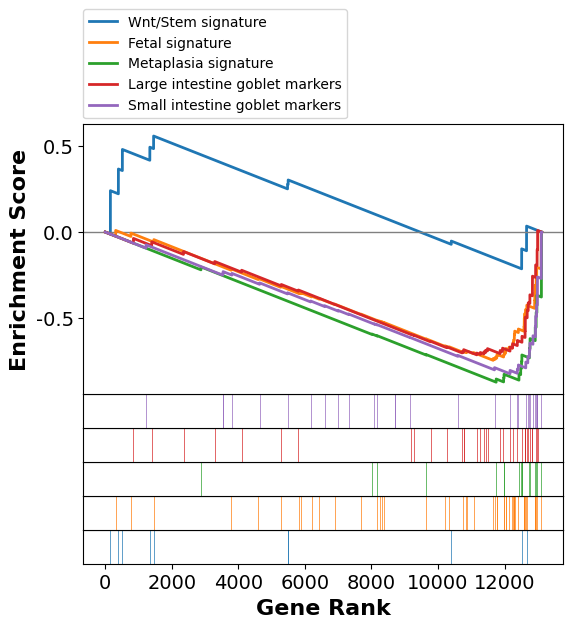

In [1385]:
Joanito_ax = Joanito_custom_out.plot(
    terms=Term_oi,
    show_ranking=False,
)

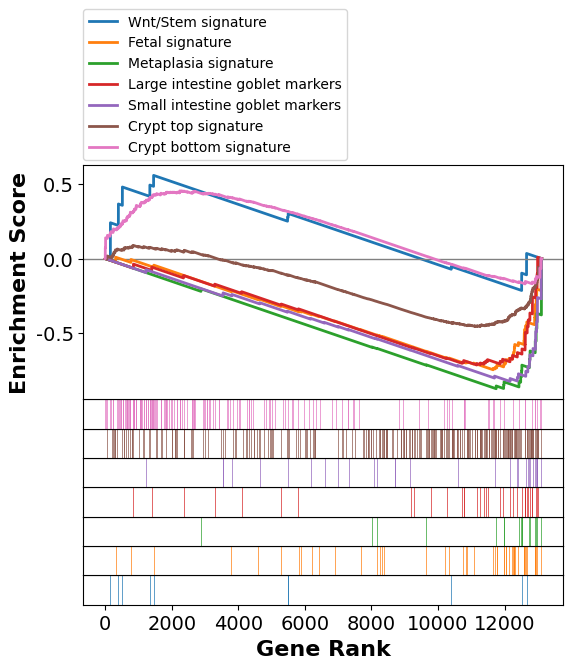

In [1387]:
Term_oi = ['Wnt/Stem signature', 'Fetal signature', 'Metaplasia signature', 'Large intestine goblet markers', 'Small intestine goblet markers', 'Crypt top signature', 'Crypt bottom signature']


Joanito_ax = Joanito_custom_out.plot(
    terms=Term_oi,
    show_ranking=False,
)


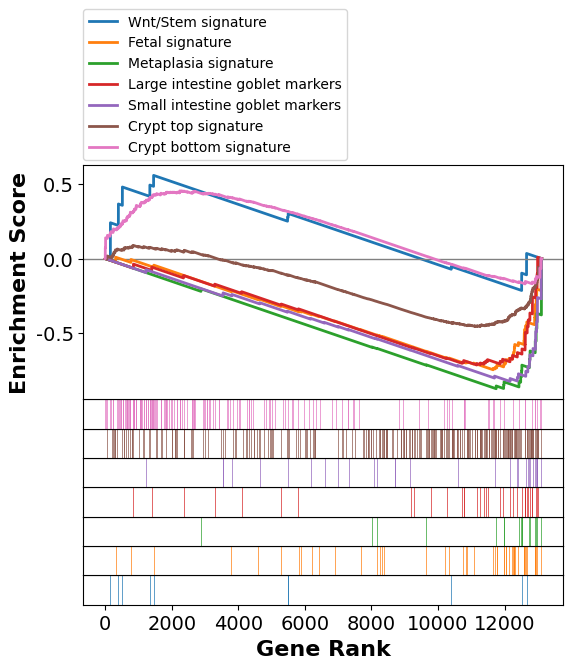

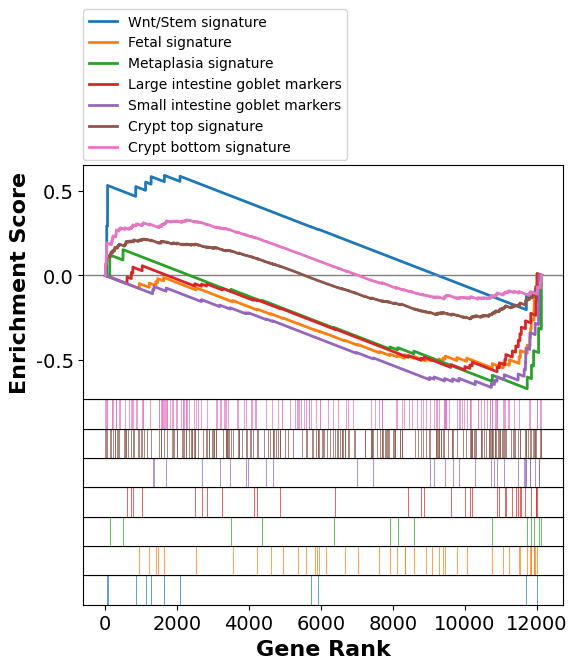

In [1386]:
Term_oi = ['Wnt/Stem signature', 'Fetal signature', 'Metaplasia signature', 'Large intestine goblet markers', 'Small intestine goblet markers', 'Crypt top signature', 'Crypt bottom signature']


Joanito_ax = Joanito_custom_out.plot(
    terms=Term_oi,
    show_ranking=False,
)


# Get the figure and save it with high DPI
fig = Joanito_ax.get_figure()  # Assuming multiple plots, take the first one
fig.savefig("/node200data/18parkky/datasets/data/public/processed_data/CRC_MSI_intensity_analysis/GSEApy/Joanito_GSEA_figure.png", 
            dpi=500, bbox_inches="tight",)  # Set high DPI

Chen_ax = Chen_custom_out.plot(
    terms=Term_oi,
    show_ranking=False,
)

# Get the figure and save it with high DPI
fig = Chen_ax.get_figure()  # Assuming multiple plots, take the first one
fig.savefig("/node200data/18parkky/datasets/data/public/processed_data/CRC_MSI_intensity_analysis/GSEApy/Chen_GSEA_figure.png", 
            dpi=500, bbox_inches="tight",)  # Set high DPI

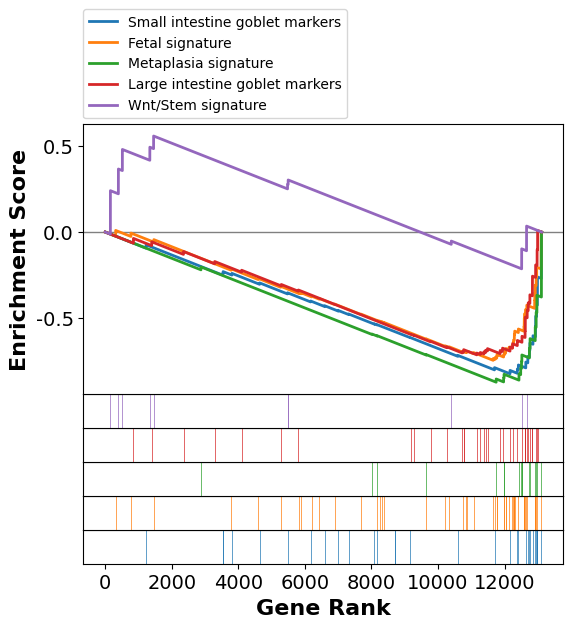

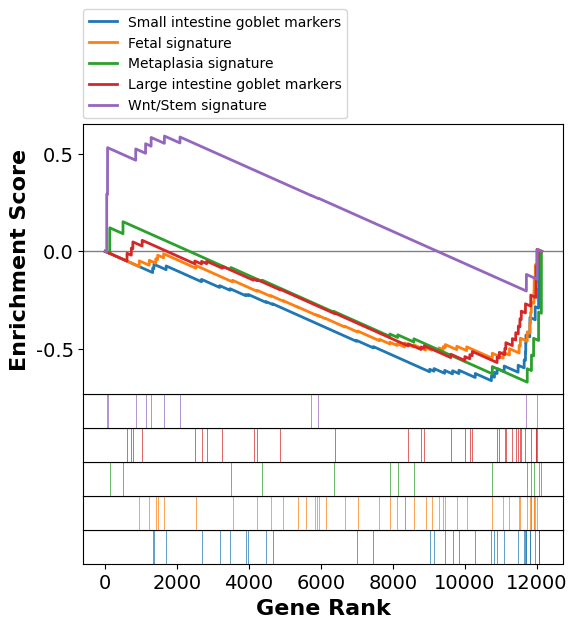

In [661]:
ax = Joanito_custom_out.plot(terms=list(Joanito_GSEA_custom_out_significant['Term']), show_ranking=False,)
ax = Chen_custom_out.plot(terms=list(Joanito_GSEA_custom_out_significant['Term']), show_ranking=False, )

## Violinplot of Intersecting genes among patients

In [43]:
sns.color_palette('deep')

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [44]:
adata_epi_joanito_tumor = adata_epi_joanito[(adata_epi_joanito.obs['Manual_CellType_lvl_1']=='Tumor epithelial') & 
                                            (adata_epi_joanito.obs['MSI']=='MSI-H')].copy()
sc.pp.normalize_total(adata_epi_joanito_tumor)
sc.pp.log1p(adata_epi_joanito_tumor)

sc.tl.score_genes(adata_epi_joanito_tumor, intersecting_up, score_name='intersecting_up')
sc.tl.score_genes(adata_epi_joanito_tumor, intersecting_down, score_name='intersecting_dw')

In [50]:
sns.color_palette('deep')

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


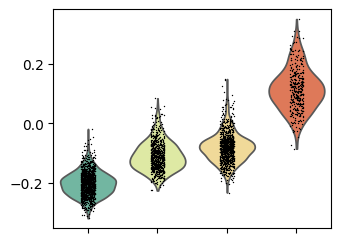

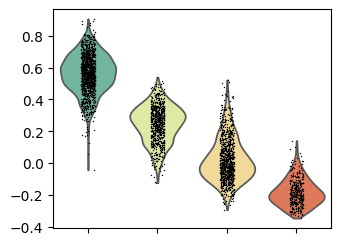

In [75]:
with plt.rc_context({"figure.dpi": (100), 'figure.figsize':(4, 3)},):
    ax = sc.pl.violin(adata_epi_joanito_tumor, keys=['intersecting_up'], groupby='PatientID', order=joanito_patient_order_by_MSI_intensity, 
                 palette=sns.color_palette("Spectral", as_cmap=False, n_colors=4)[::-1],
                 show=False,
                 )
    ax.set_xlabel('');
    ax.set_ylabel('');
    ax.set_xticklabels([]);
    # ax.set_yticklabels([]);
    
with plt.rc_context({"figure.dpi": (100), 'figure.figsize':(4, 3)},):
    ax = sc.pl.violin(adata_epi_joanito_tumor, keys=['intersecting_dw'], groupby='PatientID', order=joanito_patient_order_by_MSI_intensity, 
                 palette=sns.color_palette("Spectral", as_cmap=False, n_colors=4)[::-1],
                 show=False,
                 )
    ax.set_xlabel('');
    ax.set_ylabel('');
    ax.set_xticklabels([]);
    # ax.set_yticklabels([]);

In [52]:
adata_epi_chen_tumor = adata_epi_chen[(adata_epi_chen.obs['Manual_CellType_lvl_1']=='Tumor epithelial') & (adata_epi_chen.obs['MSI']=='MSI')].copy()
sc.pp.normalize_total(adata_epi_chen_tumor)
sc.pp.log1p(adata_epi_chen_tumor)

sc.tl.score_genes(adata_epi_chen_tumor, intersecting_up, score_name='intersecting_up')
sc.tl.score_genes(adata_epi_chen_tumor, intersecting_down, score_name='intersecting_dw')

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


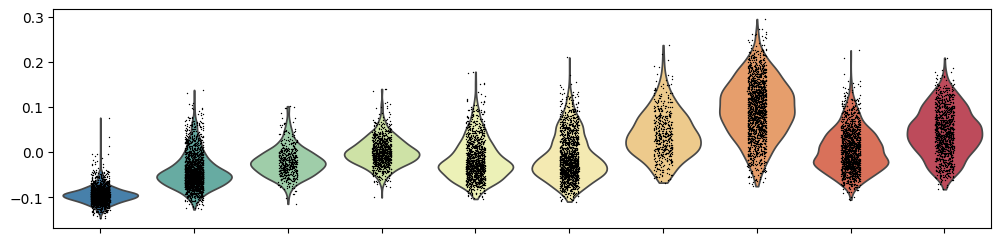

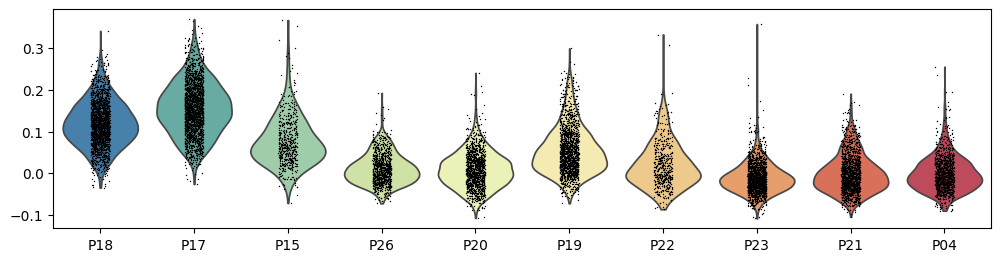

In [77]:
with plt.rc_context({"figure.dpi": (100), 'figure.figsize':(10, 3)},):
    ax = sc.pl.violin(adata_epi_chen_tumor, keys=['intersecting_up'], groupby='PatientID', order=chen_patient_order_by_MSI_intensity, 
                 palette=sns.color_palette("Spectral", as_cmap=False, n_colors=10)[::-1],
                 show=False,
                 )
    ax.set_xlabel('');
    ax.set_ylabel('');
    ax.set_xticklabels([]);
    # ax.set_yticklabels([]);

with plt.rc_context({"figure.dpi": (100), 'figure.figsize':(10, 3)},):
    ax = sc.pl.violin(adata_epi_chen_tumor, keys=['intersecting_dw'], groupby='PatientID', order=chen_patient_order_by_MSI_intensity, 
                 palette=sns.color_palette("Spectral", as_cmap=False, n_colors=10)[::-1],
                 show=False,
                 )
    ax.set_xlabel('');
    ax.set_ylabel('');
    # ax.set_xticklabels([]);
    # ax.set_yticklabels([]);


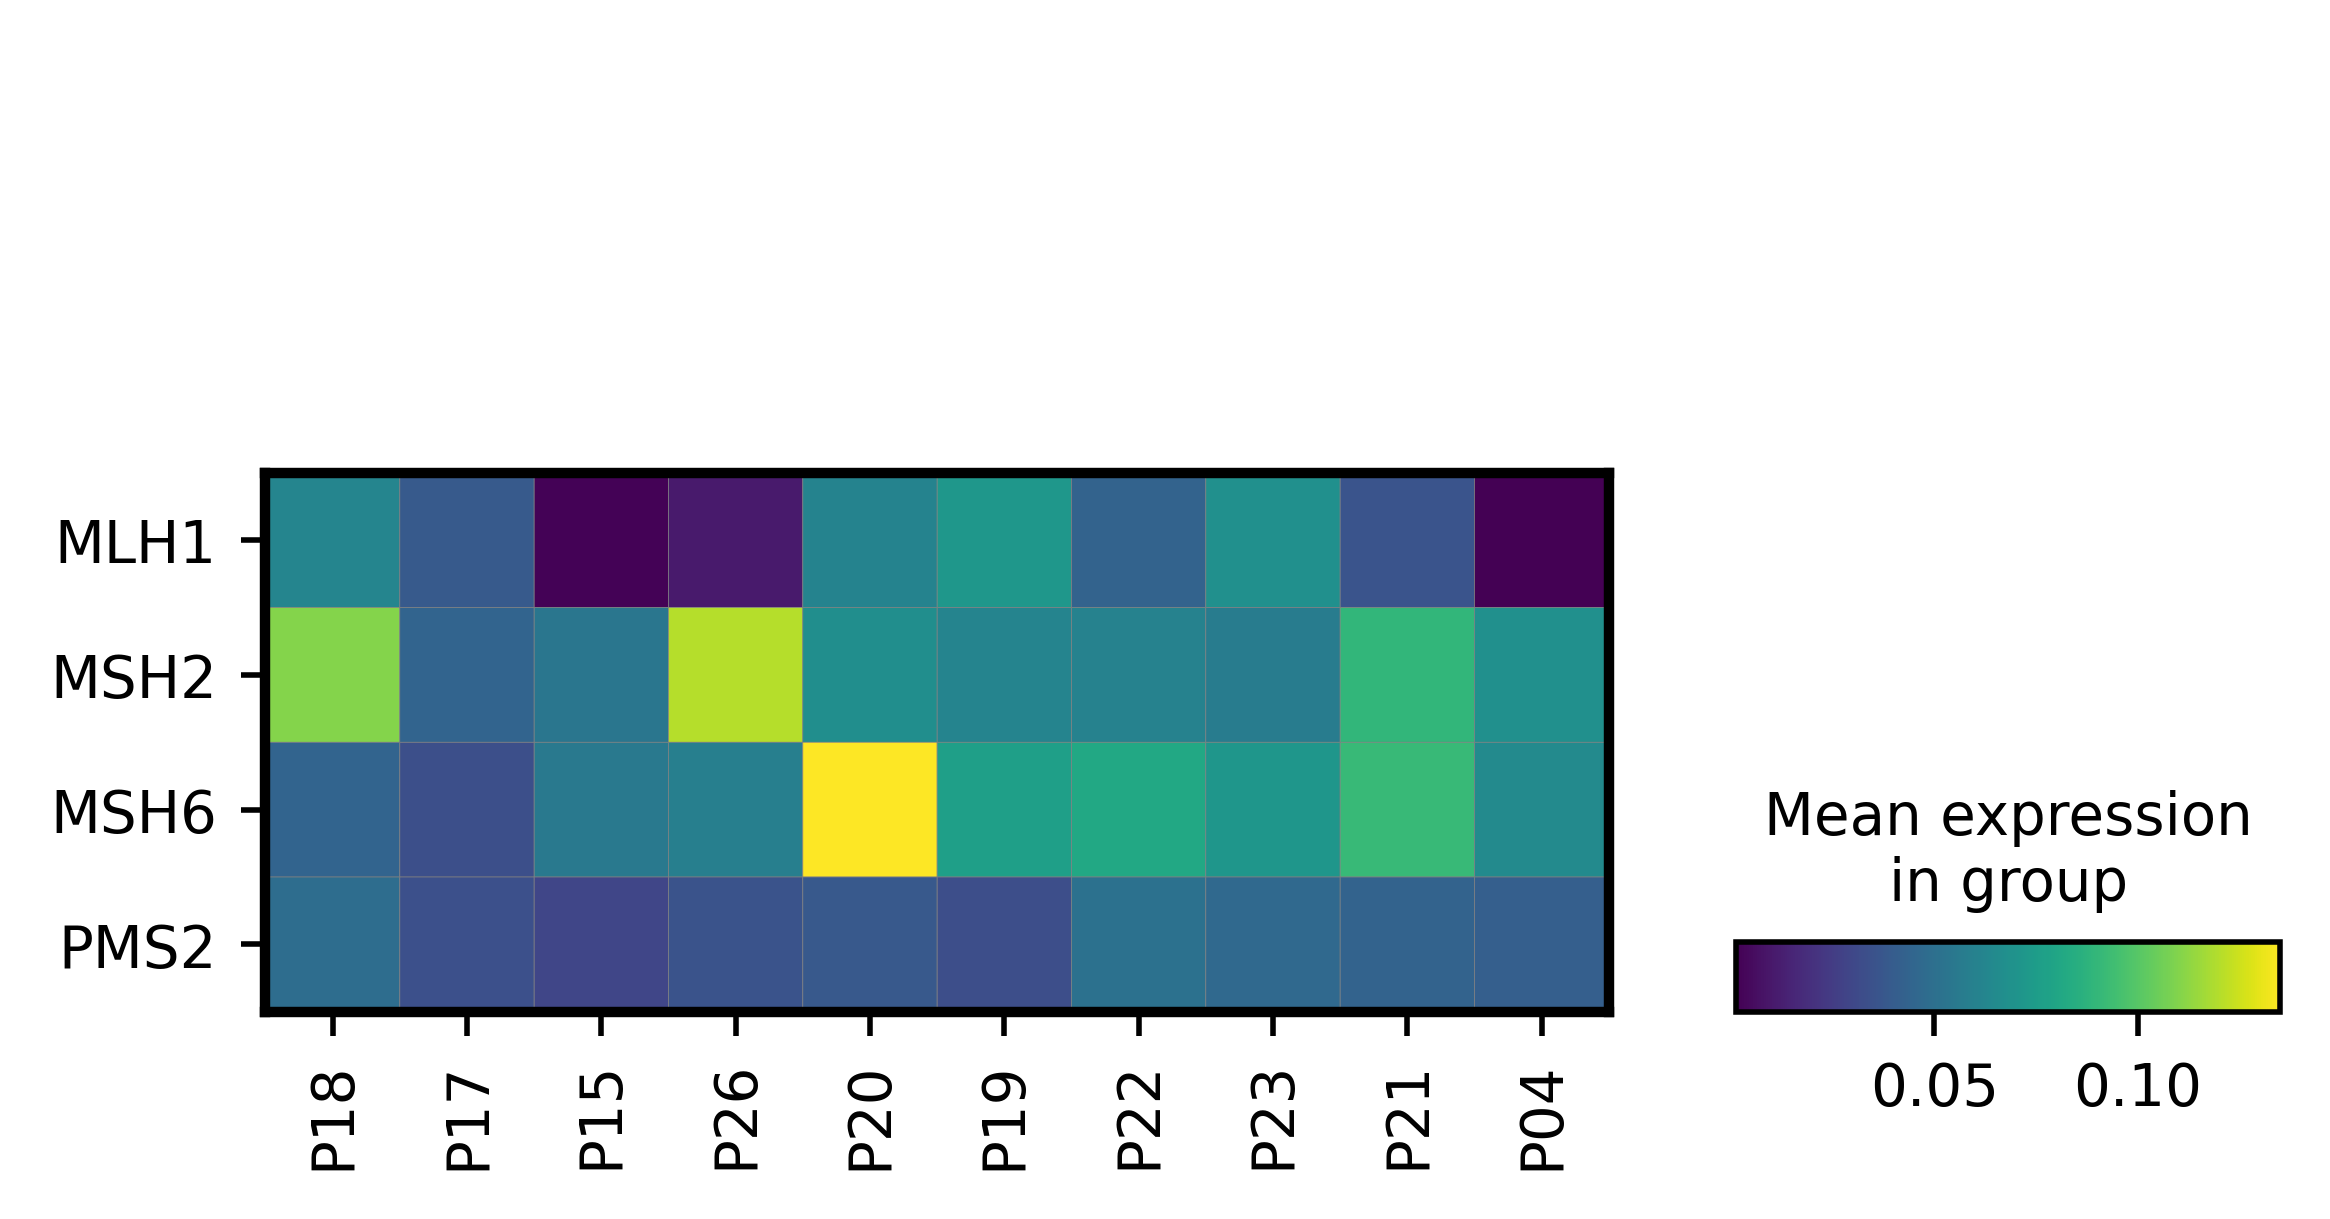

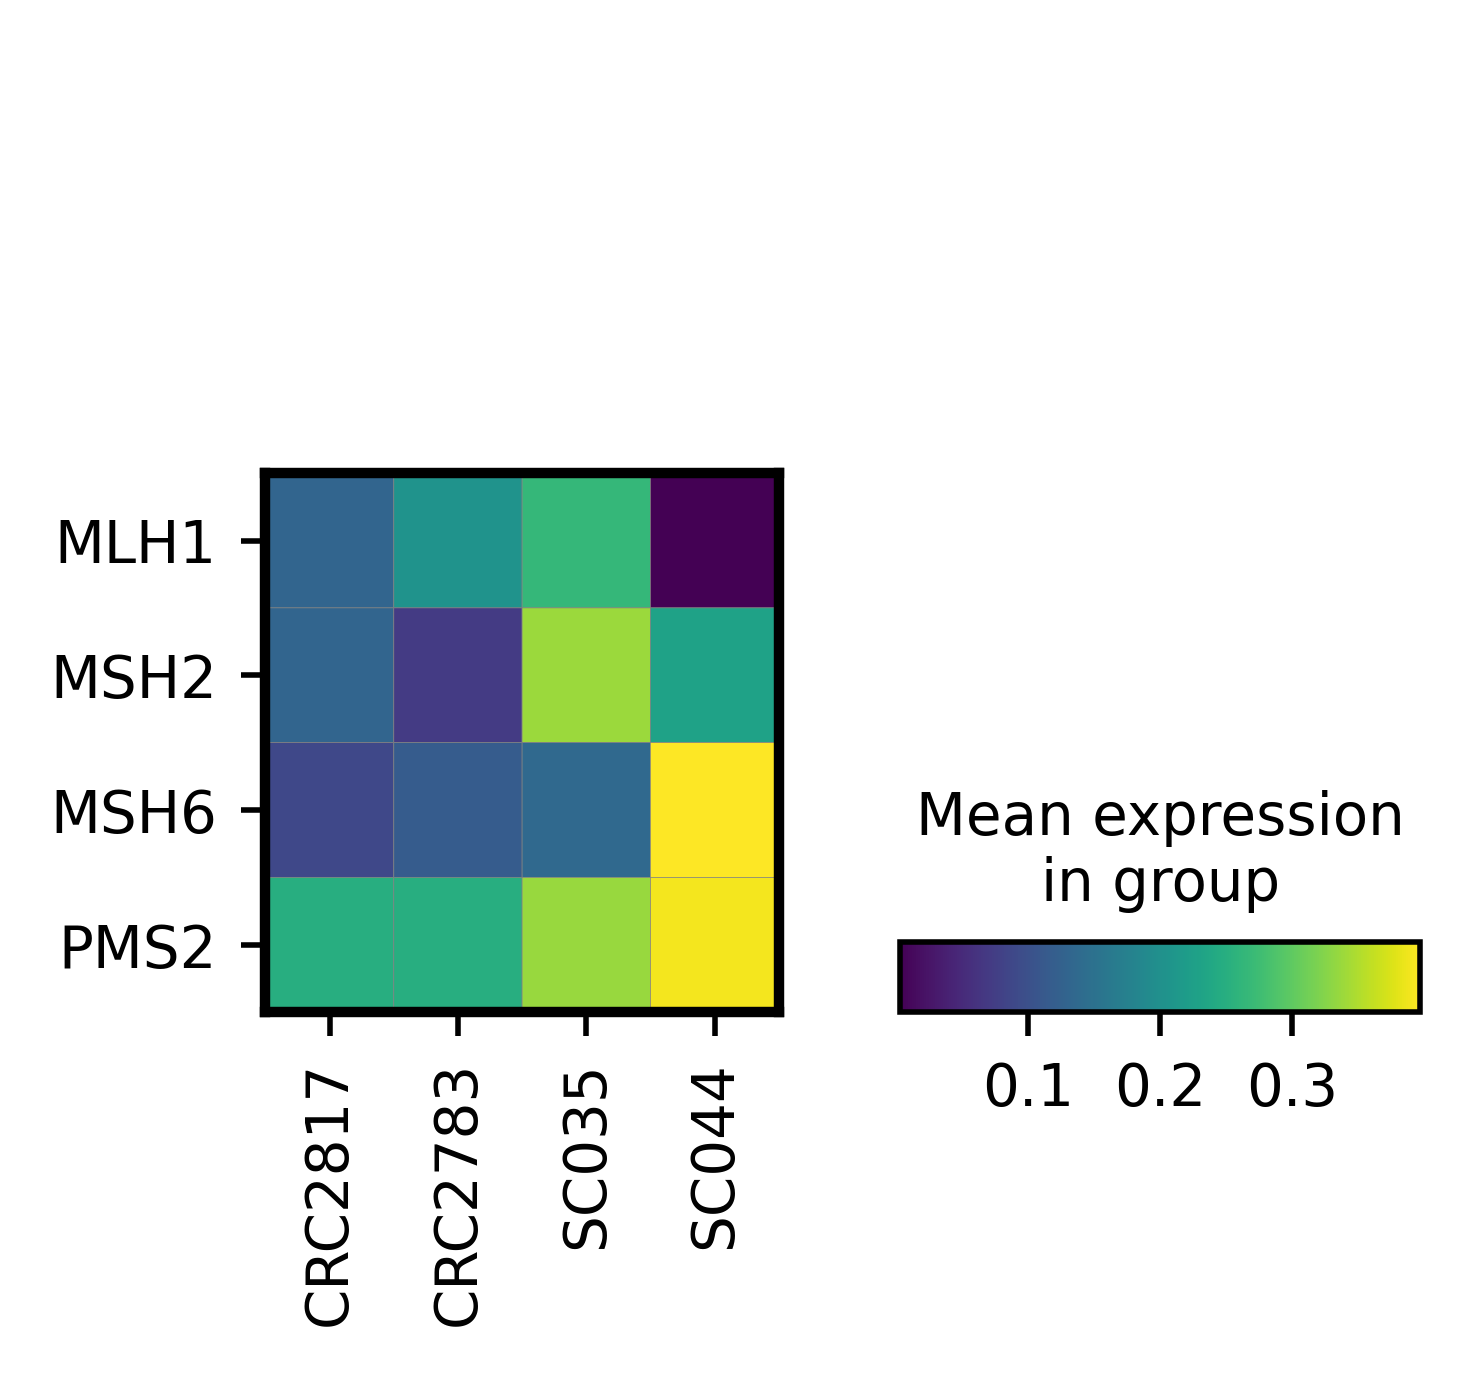

In [105]:

with plt.rc_context({"figure.dpi": (500), 'figure.figsize':(10, 1)},):
    ax = sc.pl.matrixplot(adata_epi_chen_tumor, var_names=['MLH1', 'MSH2', 'MSH6', 'PMS2'], 
                          groupby='PatientID', categories_order=chen_patient_order_by_MSI_intensity, 
                        #   standard_scale='var',
                          cmap='viridis', show=False, swap_axes=True)
    sc.pl.matrixplot(adata_epi_joanito_tumor, var_names=['MLH1', 'MSH2', 'MSH6', 'PMS2'], 
                     groupby='PatientID', categories_order=joanito_patient_order_by_MSI_intensity,
                    # standard_scale='var',
                     cmap='viridis', swap_axes=True)

## Comparison of MSI cells, normal cells and iCMS3 MSS cells

### Load data

In [1393]:
adata_chen      = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.ManualAnnot.MSI_score_labeled.h5ad')
adata_joanito   = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.MSI.preprocessed.NanoMnT.ManualAnnot.MSI_score_labeled.h5ad')

In [1394]:
dict_Joanitio_Identifier_to_CellType_lvl_1 = dict()
d = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/B_and_T.lvl1.pickle')
for k,v in d.items(): dict_Joanitio_Identifier_to_CellType_lvl_1[k]=v
d = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/Mye_and_Epi.lvl1.pickle')
for k,v in d.items(): dict_Joanitio_Identifier_to_CellType_lvl_1[k]=v
d = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/Stromal.lvl1.pickle')
for k,v in d.items(): dict_Joanitio_Identifier_to_CellType_lvl_1[k]=v

dict_Joanitio_Identifier_to_CellType_lvl_2 = dict()
d = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/B_and_T.lvl2.pickle')
for k,v in d.items(): dict_Joanitio_Identifier_to_CellType_lvl_2[k]=v
d = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/Mye_and_Epi.lvl2.pickle')
for k,v in d.items(): dict_Joanitio_Identifier_to_CellType_lvl_2[k]=v
d = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/Stromal.lvl2.pickle')
for k,v in d.items(): dict_Joanitio_Identifier_to_CellType_lvl_2[k]=v

for Identifier in adata_joanito.obs['Identifier']:
    try: 
        dict_Joanitio_Identifier_to_CellType_lvl_1[Identifier]
        dict_Joanitio_Identifier_to_CellType_lvl_2[Identifier]
    except KeyError: 
        dict_Joanitio_Identifier_to_CellType_lvl_1[Identifier] = 'Tumor epithelial'
        dict_Joanitio_Identifier_to_CellType_lvl_2[Identifier] = 'Tumor epithelial'
    
adata_joanito.obs['Manual_CellType_lvl_1'] = [ dict_Joanitio_Identifier_to_CellType_lvl_1[identifier] for identifier in adata_joanito.obs['Identifier'] ]
adata_joanito.obs['Manual_CellType_lvl_2'] = [ dict_Joanitio_Identifier_to_CellType_lvl_2[identifier] for identifier in adata_joanito.obs['Identifier'] ]

In [1395]:
dict_Chen_Identifier_to_CellType_lvl_1 = dict()
d = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/B_and_T.lvl1.pickle')
for k,v in d.items(): dict_Chen_Identifier_to_CellType_lvl_1[k]=v
d = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/Mye_and_Epi.lvl1.pickle')
for k,v in d.items(): dict_Chen_Identifier_to_CellType_lvl_1[k]=v
d = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/Stromal.lvl1.pickle')
for k,v in d.items(): dict_Chen_Identifier_to_CellType_lvl_1[k]=v

dict_Chen_Identifier_to_CellType_lvl_2 = dict()
d = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/B_and_T.lvl2.pickle')
for k,v in d.items(): dict_Chen_Identifier_to_CellType_lvl_2[k]=v
d = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/Mye_and_Epi.lvl2.pickle')
for k,v in d.items(): dict_Chen_Identifier_to_CellType_lvl_2[k]=v
d = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/Stromal.lvl2.pickle')
for k,v in d.items(): dict_Chen_Identifier_to_CellType_lvl_2[k]=v

for Identifier in adata_chen.obs['Identifier']:
    try: 
        dict_Chen_Identifier_to_CellType_lvl_1[Identifier]
        dict_Chen_Identifier_to_CellType_lvl_2[Identifier]
    except KeyError: 
        dict_Chen_Identifier_to_CellType_lvl_1[Identifier] = 'Tumor epithelial'
        dict_Chen_Identifier_to_CellType_lvl_2[Identifier] = 'Tumor epithelial'
    
adata_chen.obs['Manual_CellType_lvl_1'] = [ dict_Chen_Identifier_to_CellType_lvl_1[identifier] for identifier in adata_chen.obs['Identifier'] ]
adata_chen.obs['Manual_CellType_lvl_2'] = [ dict_Chen_Identifier_to_CellType_lvl_2[identifier] for identifier in adata_chen.obs['Identifier'] ]

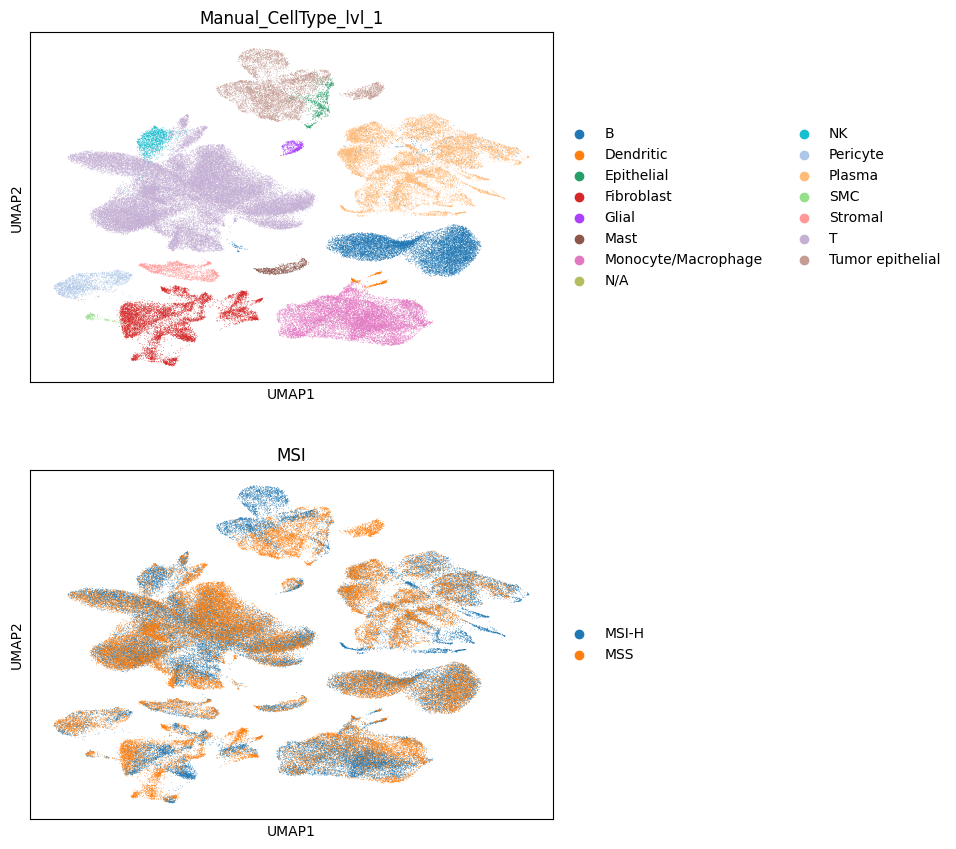

In [805]:
sc.pl.umap(adata_joanito, color=['Manual_CellType_lvl_1', 'MSI'], ncols=1)

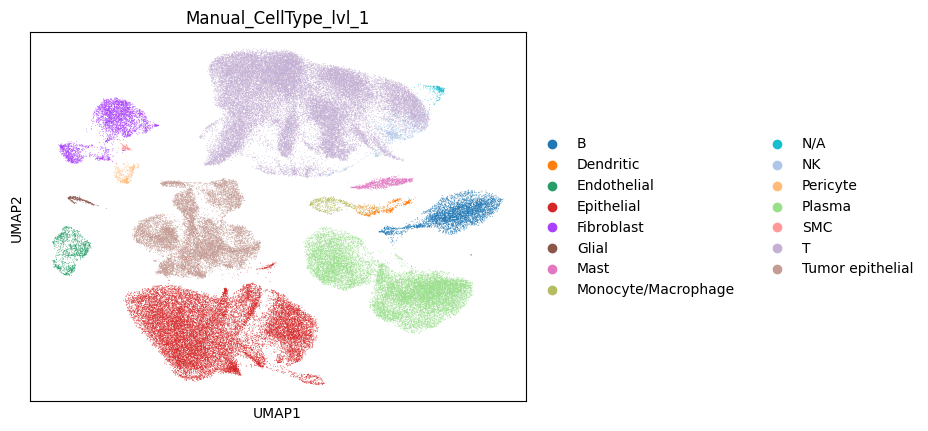

In [808]:
sc.pl.umap(adata_chen, color=['Manual_CellType_lvl_1',], ncols=1)

In [1396]:
adata_joanito.obs['dataset']    = 'Joanito et al'
adata_chen.obs['dataset']       = 'Chen et al'

iCMS3_patients = set(joanito_patient_metadata[(joanito_patient_metadata['iCMS.transcriptomic']=='iCMS3')]['patient.ID'])
# adata_concat = sc.concat([adata_joanito[(adata_joanito.obs['Manual_CellType_lvl_1'].isin(['Epithelial', 'Tumor epithelial'])) & (adata_joanito.obs['PatientID'].isin( iCMS3_patients ))].raw.to_adata(), 
#                           adata_chen[(adata_chen.obs['Manual_CellType_lvl_1'].isin(['Epithelial', 'Tumor epithelial']))].raw.to_adata()])
adata_concat = sc.concat([adata_joanito[(adata_joanito.obs['Manual_CellType_lvl_1'].isin(['Tumor epithelial'])) & (adata_joanito.obs['PatientID'].isin( iCMS3_patients ))].raw.to_adata(), 
                          adata_chen[(adata_chen.obs['Manual_CellType_lvl_1'].isin(['Tumor epithelial']))].raw.to_adata()])
adata_concat.obs['MSI'] = [ MSI.split('-')[0] for MSI in adata_concat.obs['MSI'] ]

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [1397]:
adata_concat.raw = adata_concat
sc.pp.normalize_total(adata_concat)
sc.pp.log1p(adata_concat)

In [1398]:
sc.pp.highly_variable_genes(adata_concat, n_top_genes=2000, batch_key="dataset")
adata_concat = adata_concat[:, adata_concat.var.highly_variable]

In [1288]:
sc.pp.scale(adata_concat, max_value=10)
sc.tl.pca(adata_concat, svd_solver="arpack")

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [1289]:
sc.pp.neighbors(adata_concat, n_neighbors=25, n_pcs=40)
sc.tl.umap(adata_concat,)

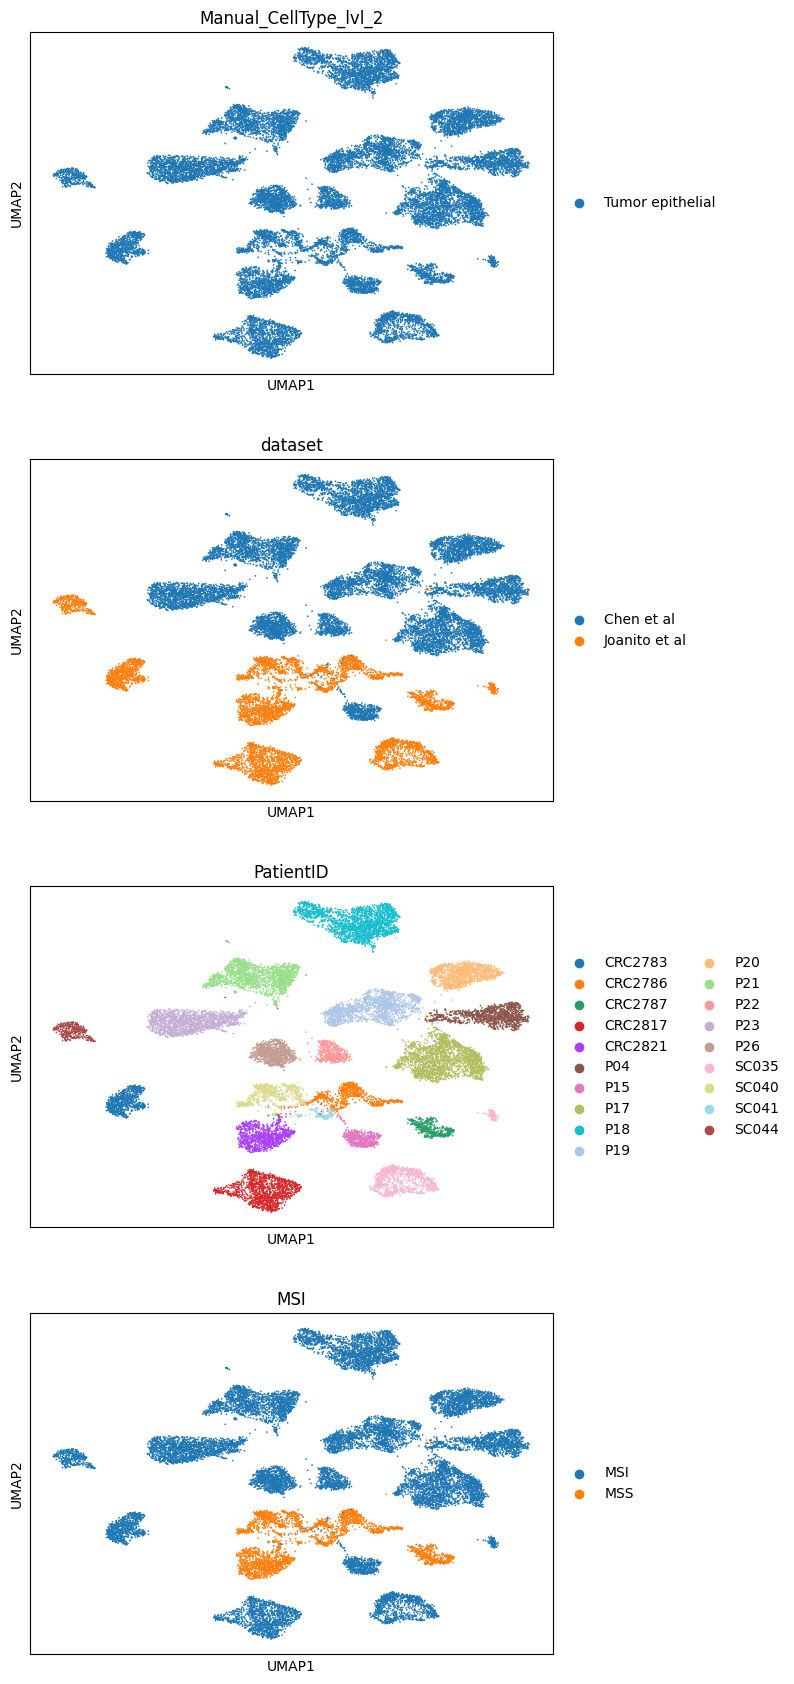

In [1356]:
sc.pl.umap(adata_concat, color=['Manual_CellType_lvl_2', 'dataset', 'PatientID', 'MSI'], ncols=1)

/tmp/ipykernel_36083/3829570614.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_concat.obs['MSI_class'] = [ dict_PatientID_to_MSI_class[PID] for PID in adata_concat.obs['PatientID'] ]
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


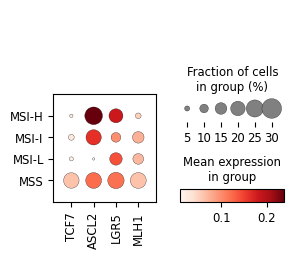

In [1399]:
adata_concat.obs['MSI_class'] = [ dict_PatientID_to_MSI_class[PID] for PID in adata_concat.obs['PatientID'] ]
sc.pl.dotplot(adata_concat, groupby='MSI_class', var_names=['TCF7', 'ASCL2', 'LGR5', 'MLH1'])

### Classify epithelial cells

In [1400]:
for PatientID in set(adata_concat.obs['PatientID']):
    try:
        dict_PatientID_to_MSI_class[PatientID]
    except KeyError:
        dict_PatientID_to_MSI_class[PatientID]='MSS'
        
adata_concat.obs['MSI_class'] = [ dict_PatientID_to_MSI_class[PID] for PID in adata_concat.obs['PatientID'] ]

In [1401]:
# MSI-H, MSI-I, MSI-L, MSS, Normal epithelial - Joanito et al.
# MSI-H, MSI-I, MSI-L, Normal epithelial - Chen et al.

dict_Identifier_to_CellType_lvl_3 = dict()
# for tup in adata_concat.obs.itertuples():
#     if tup.Manual_CellType_lvl_1 == 'Epithelial':
#         dict_Identifier_to_CellType_lvl_3[tup.Identifier] = f'Normal epithelial - {tup.dataset}'
#     else:
#         if tup.MSI == 'MSS':
#             dict_Identifier_to_CellType_lvl_3[tup.Identifier] = f'MSS CRC - {tup.dataset}'
#         else:
#             MSI_class = dict_PatientID_to_MSI_class[tup.PatientID]
#             dict_Identifier_to_CellType_lvl_3[tup.Identifier] = f'{MSI_class} CRC - {tup.dataset}'

dict_NormalCellType_unification = {
    'BEST4+ Enterocytes' : 'Enterocyte',
    'Enterocytes' : 'Enterocyte',
    'Enterocyte progenitors' : 'Enterocyte',
    'Enteroendocrine' : 'Enteroendocrine',
    'Intestinal stem' : 'Stem',
    'Stem' : 'Stem',
    'Tuft' : 'Tuft',
    'TA 1' : 'TA',
    'TA 2' : 'TA',
    'Goblet' : 'Goblet',
    'N/A' : 'N/A',
}

for tup in adata_concat.obs.itertuples():
    if tup.Manual_CellType_lvl_1 == 'Epithelial':
        dict_Identifier_to_CellType_lvl_3[tup.Identifier] = dict_NormalCellType_unification[tup.Manual_CellType_lvl_2]
    else:
        if tup.MSI == 'MSS':
            dict_Identifier_to_CellType_lvl_3[tup.Identifier] = f'iCMS3 MSS CRC'
        else:
            MSI_class = dict_PatientID_to_MSI_class[tup.PatientID]
            dict_Identifier_to_CellType_lvl_3[tup.Identifier] = f'{MSI_class} CRC'

adata_concat.obs['Manual_CellType_lvl_3'] = [ dict_Identifier_to_CellType_lvl_3[Identifier] for Identifier in adata_concat.obs['Identifier'] ]

### iCMS signature across iCMS3 CRC subtypes

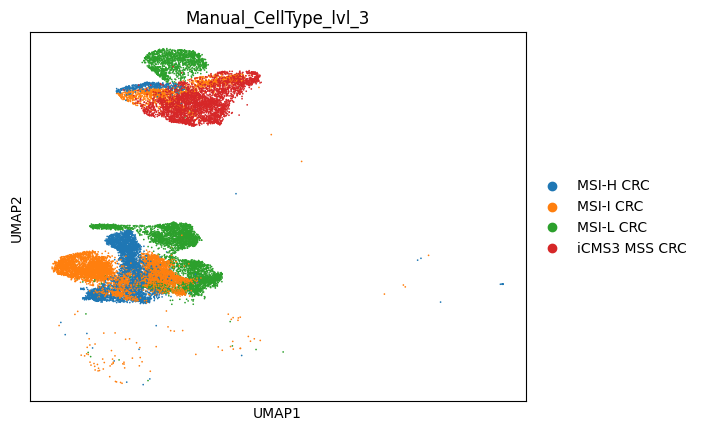

In [1402]:
sc.pl.umap(adata_concat, color=['Manual_CellType_lvl_3'])

In [1403]:
adata_concat = adata_concat.raw.to_adata()
sc.pp.normalize_total(adata_concat)
sc.pp.log1p(adata_concat)

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [1404]:
sc.tl.score_genes(adata_concat, intersecting_up,    score_name='intersecting_up')
sc.tl.score_genes(adata_concat, intersecting_down,  score_name='intersecting_dw',)

In [1405]:
sc.tl.score_genes(adata_concat, list(stem_signature),    score_name='stem')
sc.tl.score_genes(adata_concat, list(metaplasia_signature),    score_name='metaplasia')
sc.tl.score_genes(adata_concat, list(fetal_signature),    score_name='fetal')

In [1406]:
sc.tl.score_genes(adata_concat, list(iCMS2_up),    score_name='iCMS2_up')
sc.tl.score_genes(adata_concat, list(iCMS3_up),  score_name='iCMS3_up',)

       'C6orf222', 'AC004130.1', 'YAE1D1'],
      dtype='object')


In [1407]:
sc.tl.score_genes(adata_concat, list(iCMS2_dw),    score_name='iCMS2_dw')
sc.tl.score_genes(adata_concat, list(iCMS3_dw),  score_name='iCMS3_dw',)

In [1408]:
adata_concat.obs_names_make_unique()

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/utils.py:260: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['TCTTCGGCATTTCAGG-1-1', 'GCGCGATTCCTCAACC-1-1']
  warnings.warn(


In [1419]:
sns.color_palette('Paired', 10)

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509)]

In [ ]:
plt.figure
ax = sc.pl.violin(adata_concat[adata_concat.obs['dataset']=='Joanito et al'], keys='iCMS2_up', groupby='Manual_CellType_lvl_3', 
            palette={'MSI-L CRC' : palette_e[-1], 'MSI-I CRC' : 'gray', 'MSI-H CRC' : palette_e[0], 'iCMS3 MSS CRC' : 'mediumpurple'}, 
            order=['iCMS3 MSS CRC', 'MSI-L CRC', 'MSI-I CRC', 'MSI-H CRC'], 
            jitter=.2, 
            stripplot=None,
            show=False,ax=axes[0],)

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


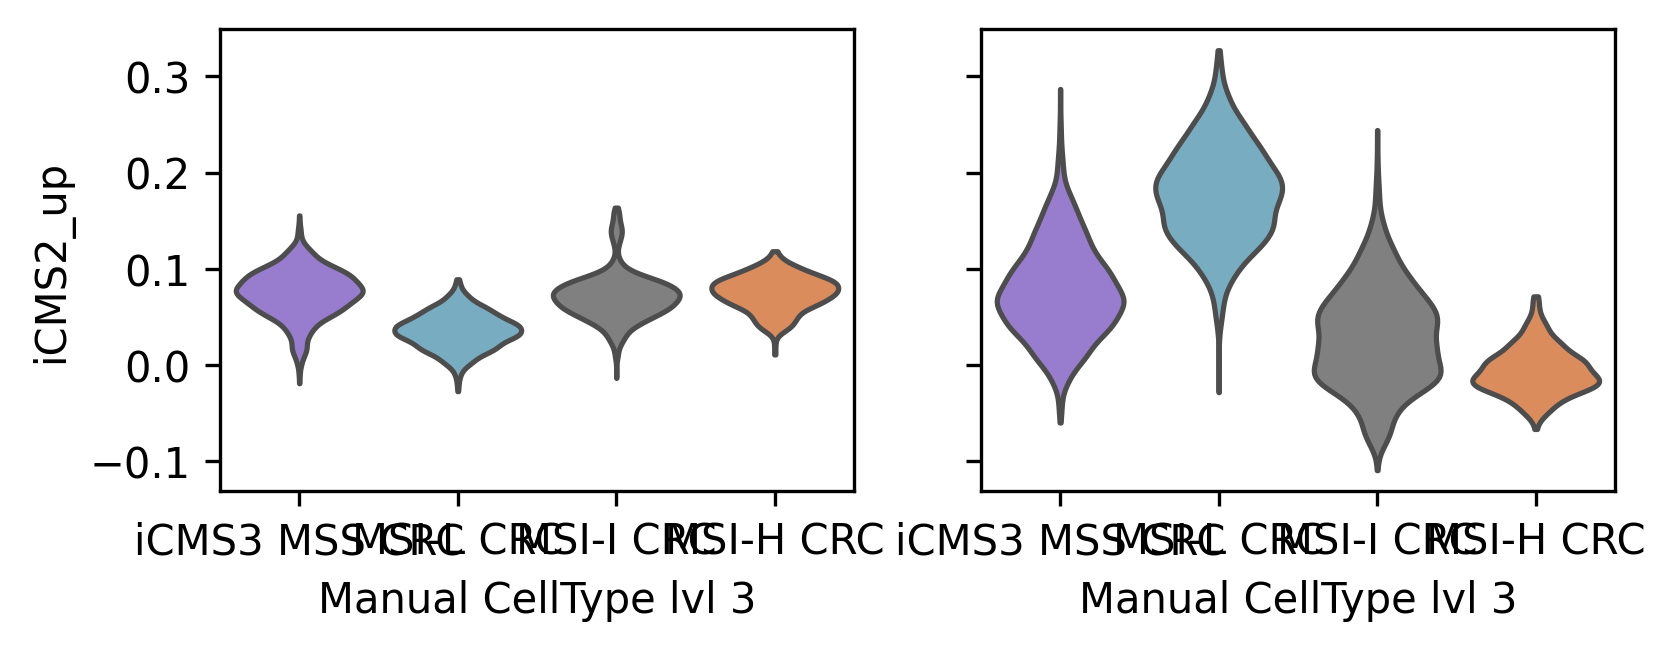

In [1607]:
# sc.pl.violin(adata_concat, keys=['iCMS2_up'], groupby='Manual_CellType_lvl_3', )

palette_e = sns.color_palette('icefire_r', 8)

fig, axes = plt.subplots(1, 2, figsize=(6, 2), dpi=300, sharey=True, sharex=True,)
ax = sc.pl.violin(adata_concat[adata_concat.obs['dataset']=='Joanito et al'], keys='iCMS2_up', groupby='Manual_CellType_lvl_3', 
            palette={'MSI-L CRC' : palette_e[-1], 'MSI-I CRC' : 'gray', 'MSI-H CRC' : palette_e[0], 'iCMS3 MSS CRC' : 'mediumpurple'}, 
            order=['iCMS3 MSS CRC', 'MSI-L CRC', 'MSI-I CRC', 'MSI-H CRC'], 
            jitter=.2, 
            stripplot=None,
            show=False,ax=axes[0],)

# ax.set_xticklabels([]);
# ax.set_xlabel('');
# ax.set_yticklabels([]);
# ax.set_ylabel('');

ax = sc.pl.violin(adata_concat[adata_concat.obs['dataset']=='Joanito et al'], keys='iCMS3_up', groupby='Manual_CellType_lvl_3', 
            palette={'MSI-L CRC' : palette_e[-1], 'MSI-I CRC' : 'gray', 'MSI-H CRC' : palette_e[0], 'iCMS3 MSS CRC' : 'mediumpurple'}, 
            order=['iCMS3 MSS CRC', 'MSI-L CRC', 'MSI-I CRC', 'MSI-H CRC'], 
            jitter=.2, 
            stripplot=None,
            show=False,ax=axes[1],)
# ax.set_xticklabels([]);
# ax.set_xlabel('');
# ax.set_yticklabels([]);
# ax.set_ylabel('');

In [1471]:
sc.tl.score_genes(adata_concat, intersecting_up, score_name='intersecting_up')
sc.tl.score_genes(adata_concat, intersecting_down, score_name='intersecting_dw')

### Visualization

#### Joanito

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


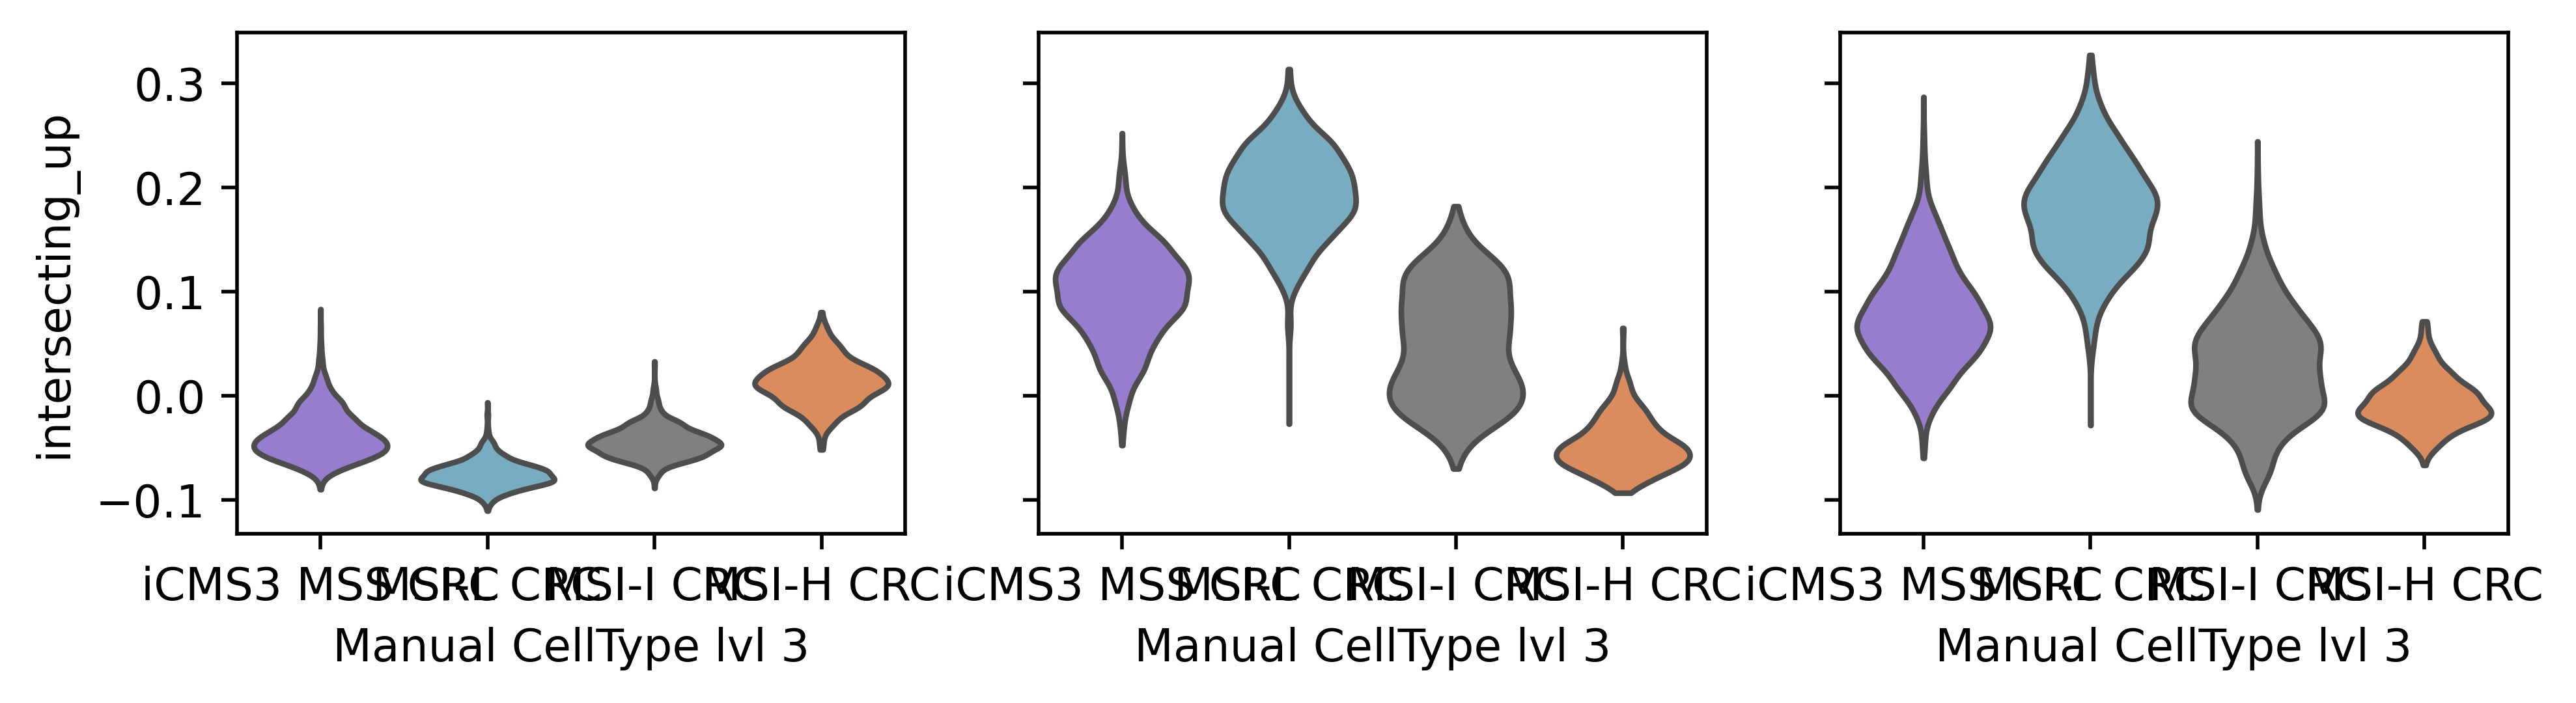

In [1610]:
palette_e = sns.color_palette('icefire_r', 8)

fig, axes = plt.subplots(1, 3, figsize=(9, 2), dpi=500, sharey=True, sharex=True,)
ax = sc.pl.violin(adata_concat[adata_concat.obs['dataset']=='Joanito et al'], keys='intersecting_up', groupby='Manual_CellType_lvl_3', 
            palette={'MSI-L CRC' : palette_e[-1], 'MSI-I CRC' : 'gray', 'MSI-H CRC' : palette_e[0], 'iCMS3 MSS CRC' : 'mediumpurple'}, order=['iCMS3 MSS CRC', 'MSI-L CRC', 'MSI-I CRC', 'MSI-H CRC',], 
            jitter=.2, 
            stripplot=None,
            show=False,ax=axes[0],)
# ax.set_xticklabels([]);
# ax.set_xlabel('');
# ax.set_yticklabels([]);
# ax.set_ylabel('');

ax = sc.pl.violin(adata_concat[adata_concat.obs['dataset']=='Joanito et al'], keys='intersecting_dw', groupby='Manual_CellType_lvl_3', 
            palette={'MSI-L CRC' : palette_e[-1], 'MSI-I CRC' : 'gray', 'MSI-H CRC' : palette_e[0], 'iCMS3 MSS CRC' : 'mediumpurple'}, order=['iCMS3 MSS CRC', 'MSI-L CRC', 'MSI-I CRC', 'MSI-H CRC',], 
            jitter=.2, 
            stripplot=None,
            show=False,ax=axes[1],)
# ax.set_xticklabels([]);
# ax.set_xlabel('');
# ax.set_yticklabels([]);
# ax.set_ylabel('');

ax = sc.pl.violin(adata_concat[adata_concat.obs['dataset']=='Joanito et al'], keys='iCMS3_up', groupby='Manual_CellType_lvl_3', 
            palette={'MSI-L CRC' : palette_e[-1], 'MSI-I CRC' : 'gray', 'MSI-H CRC' : palette_e[0], 'iCMS3 MSS CRC' : 'mediumpurple'}, order=['iCMS3 MSS CRC', 'MSI-L CRC', 'MSI-I CRC', 'MSI-H CRC',], 
            jitter=.2, 
            stripplot=None,
            show=False,ax=axes[2],)
# ax.set_xticklabels([]);
# ax.set_xlabel('');
# ax.set_yticklabels([]);
# ax.set_ylabel('');

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


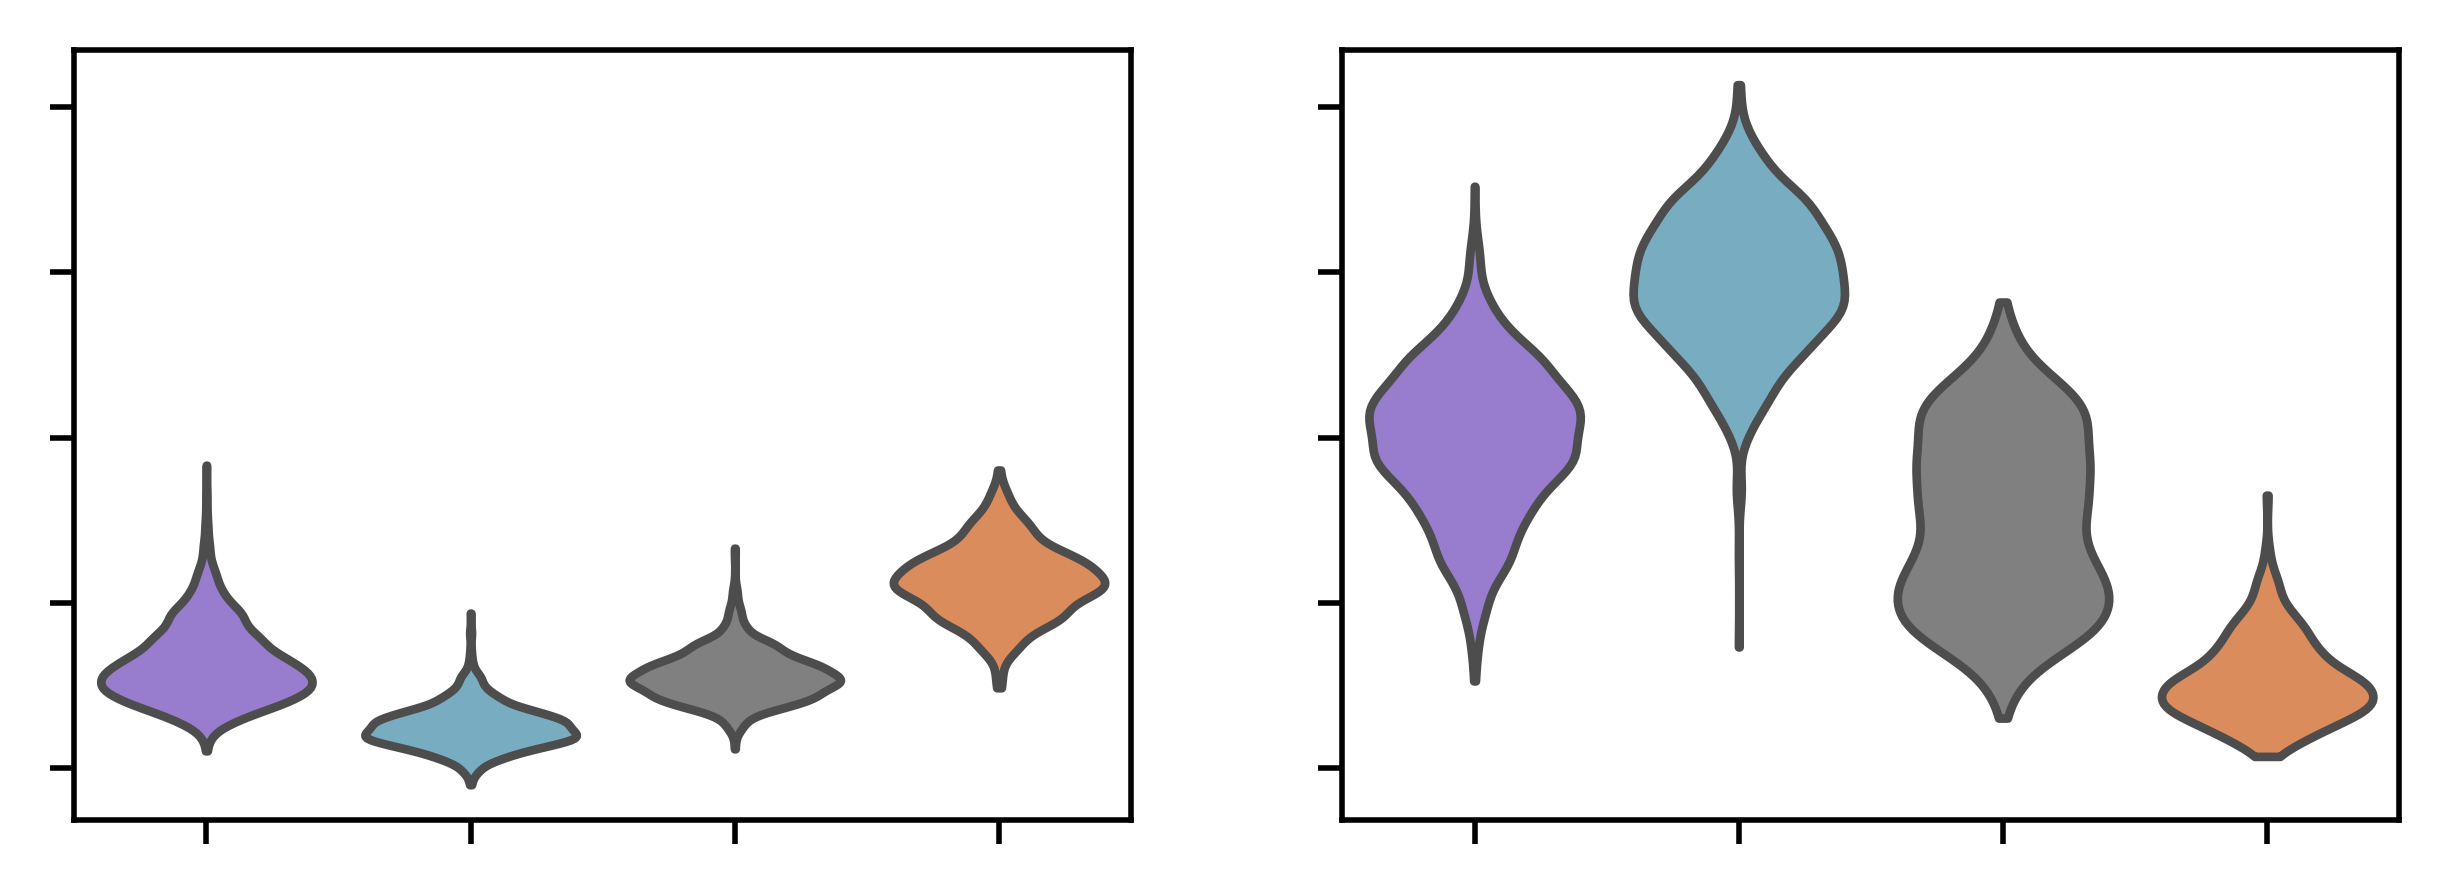

In [1488]:
palette_e = sns.color_palette('icefire_r', 8)

fig, axes = plt.subplots(1, 2, figsize=(6, 2), dpi=500, sharey=True, sharex=True,)
ax = sc.pl.violin(adata_concat[adata_concat.obs['dataset']=='Joanito et al'], keys='intersecting_up', groupby='Manual_CellType_lvl_3', 
            palette={'MSI-L CRC' : palette_e[-1], 'MSI-I CRC' : 'gray', 'MSI-H CRC' : palette_e[0], 'iCMS3 MSS CRC' : 'mediumpurple'}, order=['iCMS3 MSS CRC', 'MSI-L CRC', 'MSI-I CRC', 'MSI-H CRC',], 
            jitter=.2, 
            stripplot=None,
            show=False,ax=axes[0],)
ax.set_xticklabels([]);
ax.set_xlabel('');
ax.set_yticklabels([]);
ax.set_ylabel('');

ax = sc.pl.violin(adata_concat[adata_concat.obs['dataset']=='Joanito et al'], keys='intersecting_dw', groupby='Manual_CellType_lvl_3', 
            palette={'MSI-L CRC' : palette_e[-1], 'MSI-I CRC' : 'gray', 'MSI-H CRC' : palette_e[0], 'iCMS3 MSS CRC' : 'mediumpurple'}, order=['iCMS3 MSS CRC', 'MSI-L CRC', 'MSI-I CRC', 'MSI-H CRC',], 
            jitter=.2, 
            stripplot=None,
            show=False,ax=axes[1],)
ax.set_xticklabels([]);
ax.set_xlabel('');
ax.set_yticklabels([]);
ax.set_ylabel('');

#### Chen

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


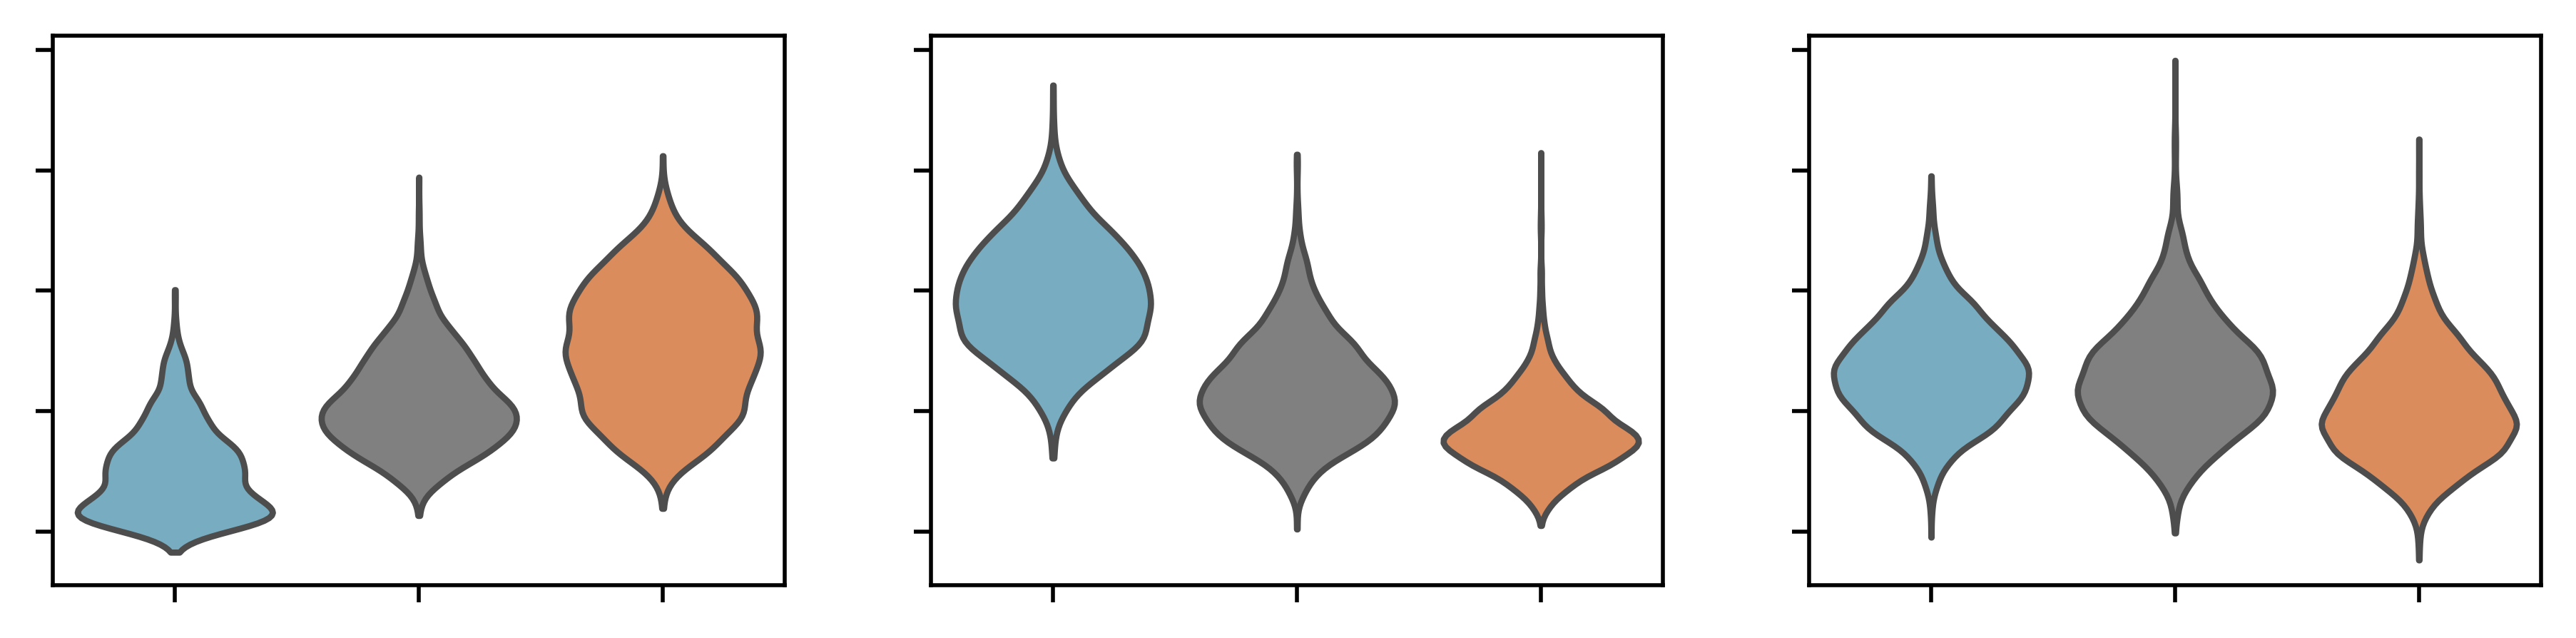

In [1613]:
palette_e = sns.color_palette('icefire_r', 8)

fig, axes = plt.subplots(1, 3, figsize=(9, 2), dpi=500, sharey=True, sharex=True,)
ax = sc.pl.violin(adata_concat[adata_concat.obs['dataset']=='Chen et al'], keys='intersecting_up', groupby='Manual_CellType_lvl_3', 
            palette={'MSI-L CRC' : palette_e[-1], 'MSI-I CRC' : 'gray', 'MSI-H CRC' : palette_e[0], 'iCMS3 MSS CRC' : 'mediumpurple'}, order=['MSI-L CRC', 'MSI-I CRC', 'MSI-H CRC',], 
            jitter=.2, 
            stripplot=None,
            show=False,ax=axes[0],)
ax.set_xticklabels([]);
ax.set_xlabel('');
ax.set_yticklabels([]);
ax.set_ylabel('');

ax = sc.pl.violin(adata_concat[adata_concat.obs['dataset']=='Chen et al'], keys='intersecting_dw', groupby='Manual_CellType_lvl_3', 
            palette={'MSI-L CRC' : palette_e[-1], 'MSI-I CRC' : 'gray', 'MSI-H CRC' : palette_e[0], 'iCMS3 MSS CRC' : 'mediumpurple'}, order=['MSI-L CRC', 'MSI-I CRC', 'MSI-H CRC',], 
            jitter=.2, 
            stripplot=None,
            show=False,ax=axes[1],)
ax.set_xticklabels([]);
ax.set_xlabel('');
ax.set_yticklabels([]);
ax.set_ylabel('');

ax = sc.pl.violin(adata_concat[adata_concat.obs['dataset']=='Chen et al'], keys='iCMS3_up', groupby='Manual_CellType_lvl_3', 
            palette={'MSI-L CRC' : palette_e[-1], 'MSI-I CRC' : 'gray', 'MSI-H CRC' : palette_e[0], 'iCMS3 MSS CRC' : 'mediumpurple'}, order=['MSI-L CRC', 'MSI-I CRC', 'MSI-H CRC',], 
            jitter=.2, 
            stripplot=None,
            show=False,ax=axes[2],)
ax.set_xticklabels([]);
ax.set_xlabel('');
ax.set_yticklabels([]);
ax.set_ylabel('');

In [1622]:
len(intersecting_up), len(intersecting_down)

(239, 177)

In [1619]:
scipy.stats.kstest(adata_concat.obs[(adata_concat.obs['dataset']=='Chen et al') & (adata_concat.obs['Manual_CellType_lvl_3']=='MSI-I CRC')]['iCMS3_up'], 
                    adata_concat.obs[(adata_concat.obs['dataset']=='Chen et al') & (adata_concat.obs['Manual_CellType_lvl_3']=='MSI-L CRC')]['iCMS3_up'])

KstestResult(statistic=0.07078000218794443, pvalue=2.517920535752744e-10, statistic_location=0.0043366449145130215, statistic_sign=1)

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


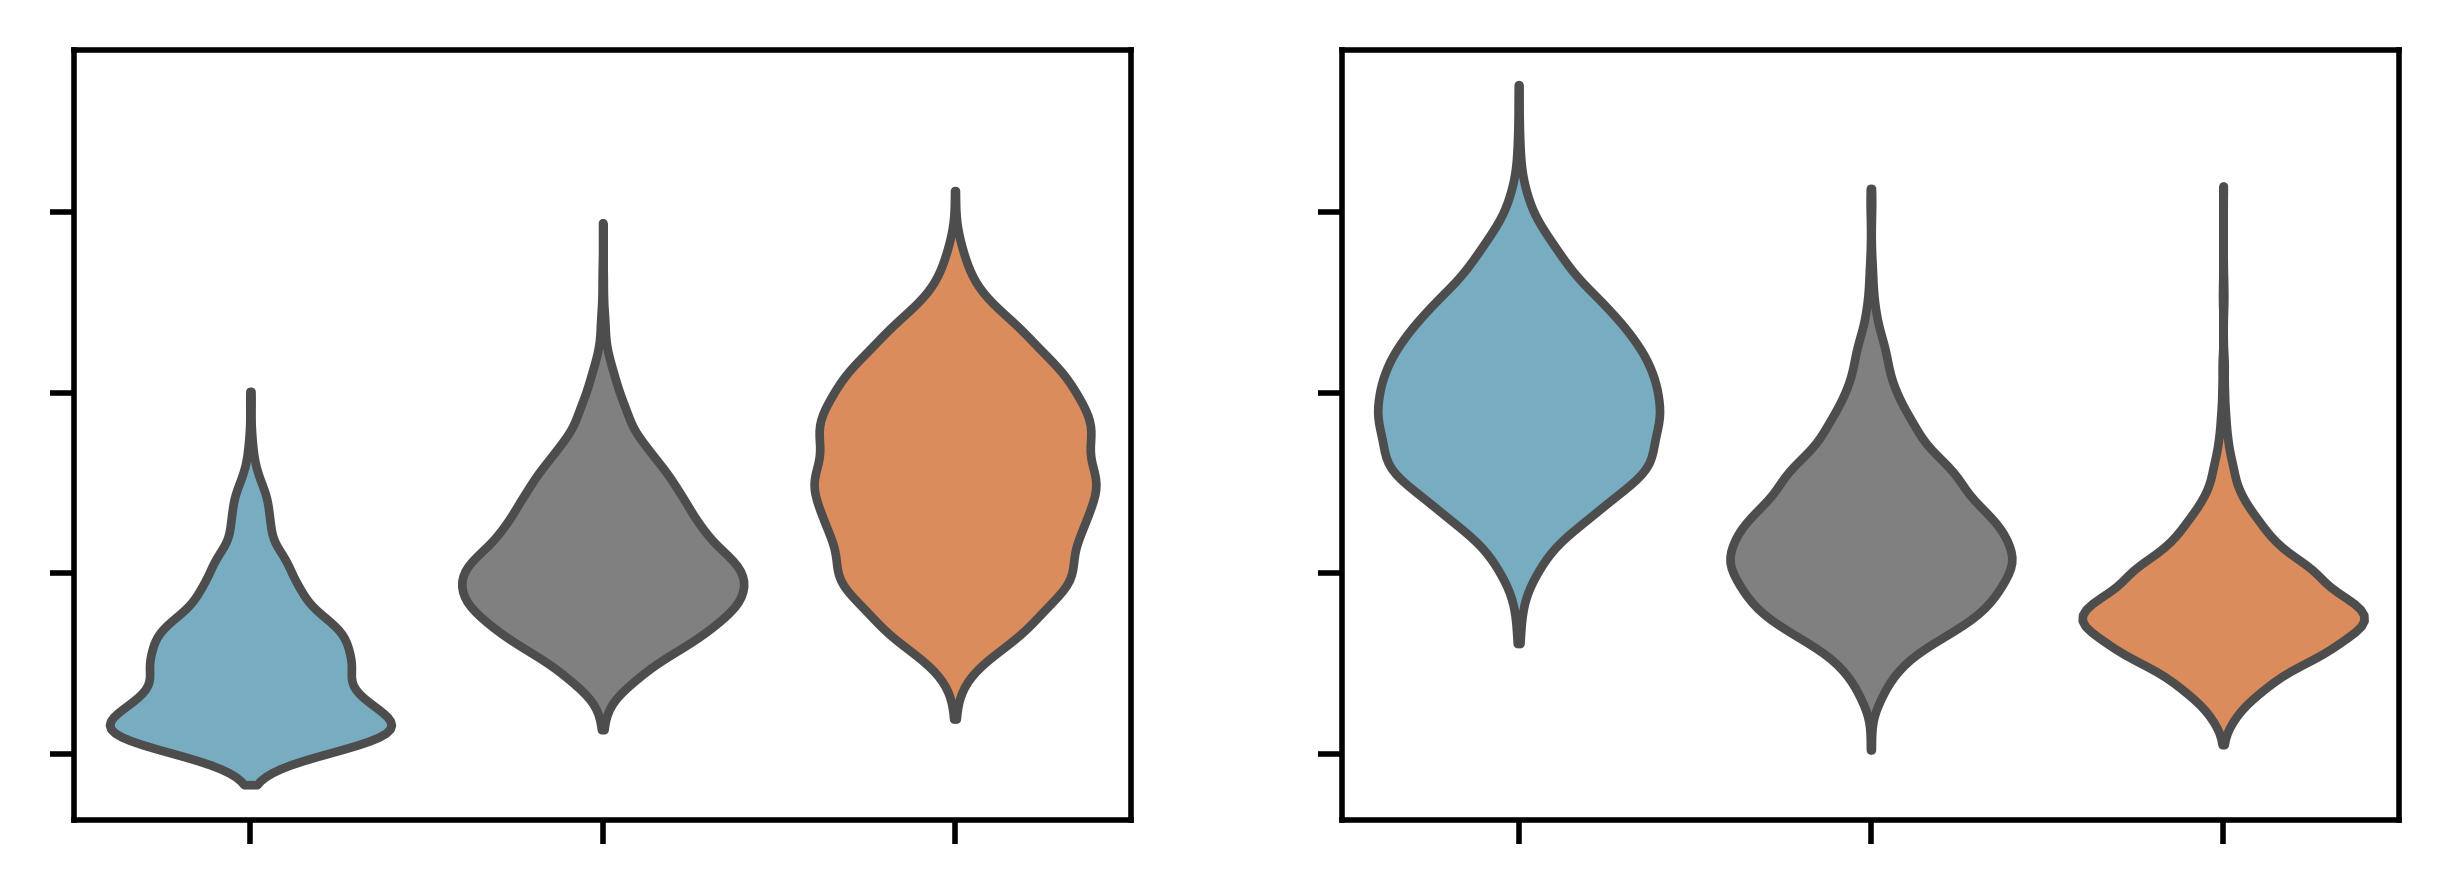

In [1484]:
# sc.pl.violin(adata_concat, keys=['intersecting_up'], groupby='Manual_CellType_lvl_3')

palette_e = sns.color_palette('icefire_r', 8)

fig, axes = plt.subplots(1, 2, figsize=(6, 2), dpi=500, sharey=True, sharex=True,)
ax = sc.pl.violin(adata_concat[adata_concat.obs['dataset']=='Chen et al'], keys='intersecting_up', groupby='Manual_CellType_lvl_3', 
            palette={'MSI-L CRC' : palette_e[-1], 'MSI-I CRC' : 'gray', 'MSI-H CRC' : palette_e[0],}, order=['MSI-L CRC', 'MSI-I CRC', 'MSI-H CRC',], 
            jitter=.2, 
            stripplot=None,
            show=False,ax=axes[0],)
ax.set_xticklabels([]);
ax.set_xlabel('');
ax.set_yticklabels([]);
ax.set_ylabel('');

ax = sc.pl.violin(adata_concat[adata_concat.obs['dataset']=='Chen et al'], keys='intersecting_dw', groupby='Manual_CellType_lvl_3', 
            palette={'MSI-L CRC' : palette_e[-1], 'MSI-I CRC' : 'gray', 'MSI-H CRC' : palette_e[0],}, order=['MSI-L CRC', 'MSI-I CRC', 'MSI-H CRC',], 
            jitter=.2, 
            stripplot=None,
            show=False,ax=axes[1],)
ax.set_xticklabels([]);
ax.set_xlabel('');
ax.set_yticklabels([]);
ax.set_ylabel('');

In [1509]:
intersecting_up

{'ABCB1',
 'AC007952.4',
 'AC019197.1',
 'AC025164.1',
 'AC025580.1',
 'ACAP3',
 'ACOT2',
 'ADA',
 'ADCK5',
 'ADD3-AS1',
 'ADGRL1',
 'ADSSL1',
 'AF064858.1',
 'AFMID',
 'AL096854.1',
 'AL118516.1',
 'AMPD3',
 'ANK3',
 'ANKRD37',
 'APOLD1',
 'ARHGAP39',
 'ARHGEF40',
 'ASCL2',
 'ATP6V1C2',
 'AURKA',
 'AZGP1',
 'BBOX1-AS1',
 'BCL11A',
 'BMP7',
 'C1QTNF1',
 'C4orf19',
 'CA12',
 'CAV2',
 'CBR3-AS1',
 'CCDC200',
 'CCL28',
 'CCN1',
 'CCN2',
 'CD24',
 'CD302',
 'CDK14',
 'CDK16',
 'CDK6',
 'CDKN1B',
 'CDX1',
 'CEBPD',
 'CES3',
 'CHRM3',
 'CHTF18',
 'CITED2',
 'CORO1A',
 'CSKMT',
 'CSRNP3',
 'CTTNBP2',
 'CYBA',
 'CYP4X1',
 'DGKZ',
 'DIP2C',
 'DISC1',
 'DLL4',
 'DOCK4',
 'DRAIC',
 'DTNB',
 'DUSP2',
 'EPHB2',
 'EPHB3',
 'ERO1B',
 'F11-AS1',
 'FAAH',
 'FAM117A',
 'FAM53C',
 'FAM83D',
 'FARP1',
 'FRAS1',
 'GABRE',
 'GADD45B',
 'GADD45G',
 'GALNS',
 'GCNT1',
 'GLCE',
 'GLI4',
 'GLIS3',
 'GMPR',
 'GNGT1',
 'GPAA1',
 'GPC4',
 'GPRC5D-AS1',
 'GRIN2B',
 'HILPDA',
 'HIST1H1B',
 'HIST1H2AG',
 'HIST1H2AL',

In [1529]:
set(adata_concat[(adata_concat.obs['dataset']=='Joanito et al') & 
                 (adata_concat.obs['MSI']=='MSS')].obs['PatientID'])

{'CRC2786', 'CRC2787', 'CRC2821', 'SC040', 'SC041'}

In [1599]:
adata_concat.layers["scaled"] = sc.pp.scale(adata_concat, copy=True).X

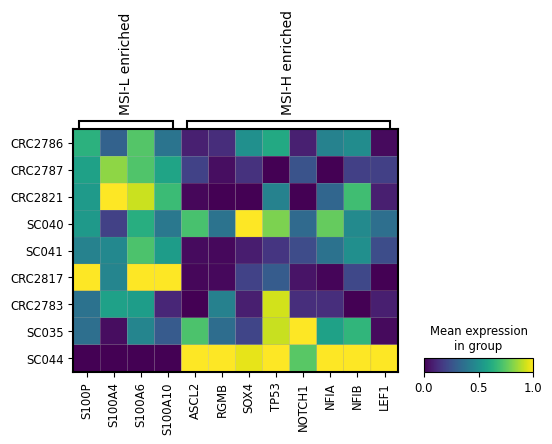

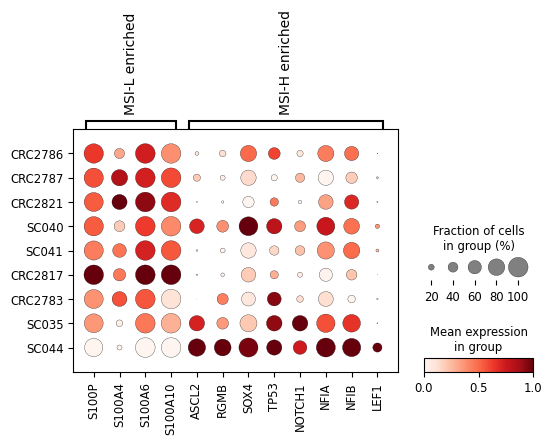

In [1605]:
sc.pl.matrixplot(adata_concat[adata_concat.obs['dataset']=='Joanito et al'], 
              var_names={'MSI-L enriched': ['S100P', 'S100A4', 'S100A6', 'S100A10',], 'MSI-H enriched' : ['ASCL2', 'RGMB', 'SOX4', 'TP53', 'NOTCH1', 'NFIA', 'NFIB', 'LEF1'],}, 
              groupby='PatientID',
              categories_order=['CRC2786', 'CRC2787', 'CRC2821', 'SC040', 'SC041'] + joanito_patient_order_by_MSI_intensity,
              standard_scale='var',
              # cmap=sns.light_palette("salmon", as_cmap=True),
              )


# sc.pl.heatmap(adata_concat[adata_concat.obs['dataset']=='Joanito et al'], 
#               var_names={'MSI-L enriched': ['S100P', 'S100A4', 'S100A6', 'S100A10',], 'MSI-H enriched' : ['ASCL2', 'RGMB', 'SOX4', 'TP53', 'NOTCH1', 'NFIA', 'NFIB', 'LEF1'],}, 
#               groupby='PatientID',
#               # categories_order=['CRC2786', 'CRC2787', 'CRC2821', 'SC040', 'SC041'] + joanito_patient_order_by_MSI_intensity,
#               # standard_scale='var',
#               layer='scaled', dendrogram=True,
#               # cmap=sns.light_palette("salmon", as_cmap=True),
#               )

sc.pl.dotplot(adata_concat[adata_concat.obs['dataset']=='Joanito et al'], 
              var_names={'MSI-L enriched': ['S100P', 'S100A4', 'S100A6', 'S100A10',], 'MSI-H enriched' : ['ASCL2', 'RGMB', 'SOX4', 'TP53', 'NOTCH1', 'NFIA', 'NFIB', 'LEF1'],}, 
              groupby='PatientID',
              categories_order=['CRC2786', 'CRC2787', 'CRC2821', 'SC040', 'SC041'] + joanito_patient_order_by_MSI_intensity,
              standard_scale='var',
              # cmap=sns.light_palette("seagreen", as_cmap=True)
              )

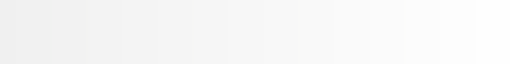

In [1583]:
sns.light_palette("white", as_cmap=True)

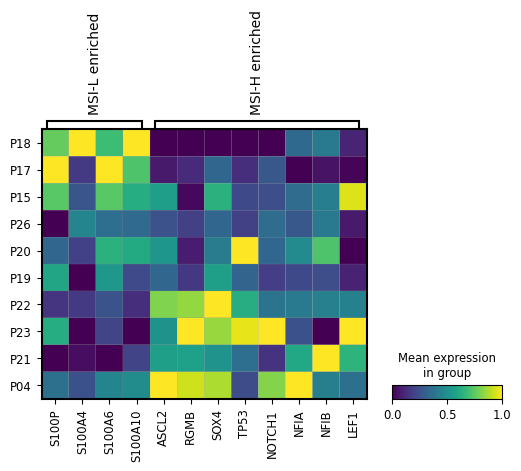

In [1534]:
sc.pl.matrixplot(adata_concat[adata_concat.obs['dataset']=='Chen et al'], 
              var_names={'MSI-L enriched': ['S100P', 'S100A4', 'S100A6', 'S100A10',], 'MSI-H enriched' : ['ASCL2', 'RGMB', 'SOX4', 'TP53', 'NOTCH1', 'NFIA', 'NFIB', 'LEF1'],}, 
              # groupby='Manual_CellType_lvl_3', 
              groupby='PatientID', categories_order=chen_patient_order_by_MSI_intensity,
              standard_scale='var',
              )

MSI-H CRC 373 -0.01
MSI-I CRC 1790 0.03
MSI-L CRC 1327 0.18
iCMS3 MSS CRC 3088 0.08


/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all

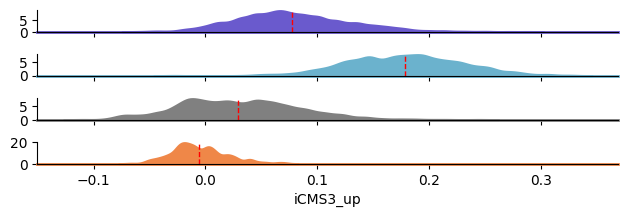

In [1454]:
vertical_lines = dict()
for Manual_CellType_lvl_3, edf in adata_concat.obs[(adata_concat.obs['dataset']=='Joanito et al')].groupby('Manual_CellType_lvl_3', observed=True): # [(adata_concat.obs['dataset']=='Joanito et al')]
    print(Manual_CellType_lvl_3, len(edf), round(np.mean(edf['iCMS3_up']), 2))
    vertical_lines[Manual_CellType_lvl_3] = np.mean(edf['iCMS3_up'])
    
celltypes_of_interest = ['Enterocyte', 'Goblet', 'TA', 'Stem', 'iCMS3 MSS CRC', 'MSI-L CRC', 'MSI-I CRC', 'MSI-H CRC']
celltypes_of_interest = ['iCMS3 MSS CRC', 'MSI-L CRC', 'MSI-I CRC', 'MSI-H CRC']

df = adata_concat.obs[(adata_concat.obs['dataset']=='Joanito et al')][['Manual_CellType_lvl_3', 'iCMS3_up']].copy()
df = df[~(df['Manual_CellType_lvl_3'].isin(['Tuft', 'N/A', 'Enteroendocrine']))]
# df['Manual_CellType_lvl_3'] = list(df['Manual_CellType_lvl_3'])
df['Manual_CellType_lvl_3'] = pd.Categorical(df['Manual_CellType_lvl_3'], categories=celltypes_of_interest, ordered=True)
df.sort_values('Manual_CellType_lvl_3', inplace=True)  # Sort according to specified order
df.reset_index(inplace=True, drop=True)

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)

pal = {
    'MSI-H CRC' : sns.color_palette('icefire', 8)[-1],
    'MSI-I CRC' : 'gray',
    'MSI-L CRC' : sns.color_palette('icefire', 8)[0],
    'iCMS3 MSS CRC' : 'slateblue',
    'Enterocyte' : sns.color_palette('gray', 8)[0],
    'Goblet' : sns.color_palette('gray', 8)[1],
    'TA' : sns.color_palette('gray', 8)[2],
    'Stem' : sns.color_palette('gray', 8)[3]
}


g = sns.FacetGrid(df, row="Manual_CellType_lvl_3", hue="Manual_CellType_lvl_3", 
                  aspect=15, sharey=False,
                  height=.5, palette=pal,)

# Draw the densities in a few steps
g.map(sns.kdeplot, "iCMS3_up",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5, common_norm=False, 
      # hue_order=['Enterocyte', 'Goblet', 'TA', 'Stem', 'MSS CRC', 'MSI-L CRC', 'MSI-I CRC', 'MSI-H CRC'],
      
      )
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

def add_vline(*args, **kwargs):
    ax = plt.gca()  # Get current axis
    cell_type = kwargs.get('label')  # Get label (cell type)
    if cell_type in vertical_lines:
        ax.axvline(vertical_lines[cell_type], color='red', linestyle="--", linewidth=1)

g.map(add_vline, "iCMS3_up")

g.figure.subplots_adjust(hspace=1)

g.set_titles("")
# g.set(yticks=[], ylabel="")
g.set( ylabel="")

# g.despine(bottom=True, left=True)

MSI-H CRC 373 0.08
MSI-I CRC 1790 0.07
MSI-L CRC 1327 0.04
iCMS3 MSS CRC 3088 0.07


/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all

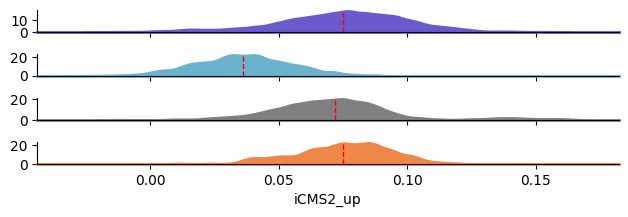

In [1453]:
vertical_lines = dict()
for Manual_CellType_lvl_3, edf in adata_concat.obs[(adata_concat.obs['dataset']=='Joanito et al')].groupby('Manual_CellType_lvl_3', observed=True): # [(adata_concat.obs['dataset']=='Joanito et al')]
    print(Manual_CellType_lvl_3, len(edf), round(np.mean(edf['iCMS2_up']), 2))
    vertical_lines[Manual_CellType_lvl_3] = np.mean(edf['iCMS2_up'])
    
celltypes_of_interest = ['Enterocyte', 'Goblet', 'TA', 'Stem', 'iCMS3 MSS CRC', 'MSI-L CRC', 'MSI-I CRC', 'MSI-H CRC']
celltypes_of_interest = ['iCMS3 MSS CRC', 'MSI-L CRC', 'MSI-I CRC', 'MSI-H CRC']

df = adata_concat.obs[(adata_concat.obs['dataset']=='Joanito et al')][['Manual_CellType_lvl_3', 'iCMS2_up']].copy()
df = df[~(df['Manual_CellType_lvl_3'].isin(['Tuft', 'N/A', 'Enteroendocrine']))]
# df['Manual_CellType_lvl_3'] = list(df['Manual_CellType_lvl_3'])
df['Manual_CellType_lvl_3'] = pd.Categorical(df['Manual_CellType_lvl_3'], categories=celltypes_of_interest, ordered=True)
df.sort_values('Manual_CellType_lvl_3', inplace=True)  # Sort according to specified order
df.reset_index(inplace=True, drop=True)

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)

pal = {
    'MSI-H CRC' : sns.color_palette('icefire', 8)[-1],
    'MSI-I CRC' : 'gray',
    'MSI-L CRC' : sns.color_palette('icefire', 8)[0],
    'iCMS3 MSS CRC' : 'slateblue',
    'Enterocyte' : sns.color_palette('gray', 8)[0],
    'Goblet' : sns.color_palette('gray', 8)[1],
    'TA' : sns.color_palette('gray', 8)[2],
    'Stem' : sns.color_palette('gray', 8)[3]
}


g = sns.FacetGrid(df, row="Manual_CellType_lvl_3", hue="Manual_CellType_lvl_3", 
                  aspect=15, sharey=False,
                  height=.5, palette=pal,)

# Draw the densities in a few steps
g.map(sns.kdeplot, "iCMS2_up",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5, common_norm=False, 
      # hue_order=['Enterocyte', 'Goblet', 'TA', 'Stem', 'MSS CRC', 'MSI-L CRC', 'MSI-I CRC', 'MSI-H CRC'],
      
      )
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

def add_vline(*args, **kwargs):
    ax = plt.gca()  # Get current axis
    cell_type = kwargs.get('label')  # Get label (cell type)
    if cell_type in vertical_lines:
        ax.axvline(vertical_lines[cell_type], color='red', linestyle="--", linewidth=1)

g.map(add_vline, "iCMS2_up")

g.figure.subplots_adjust(hspace=1)

g.set_titles("")
# g.set(yticks=[], ylabel="")
g.set( ylabel="")

# g.despine(bottom=True, left=True)

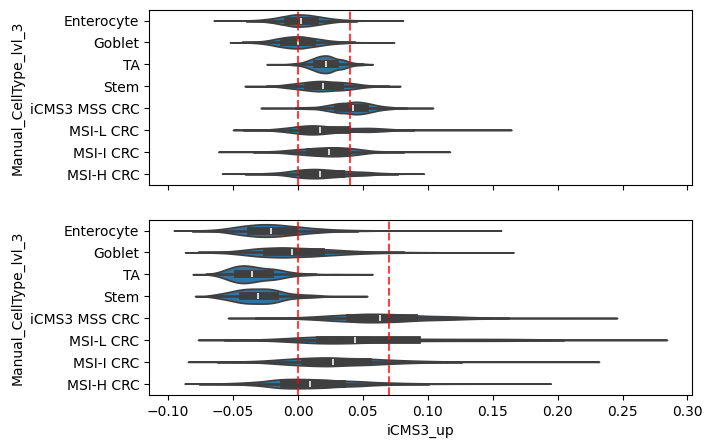

In [1077]:
fig, axes = plt.subplots(2, 1, figsize=(7, 5), sharex=True, sharey=True)

sns.violinplot(data=adata_concat.obs,
            y='Manual_CellType_lvl_3', x='iCMS2_up',
            order=['Enterocyte', 'Goblet', 'TA', 'Stem', 'iCMS3 MSS CRC', 'MSI-L CRC', 'MSI-I CRC', 'MSI-H CRC'], ax=axes[0])
axes[0].axvline( 0, color='red', ls='--', alpha=0.75 )
axes[0].axvline( 0.04, color='red', ls='--', alpha=0.75 )
sns.violinplot(data=adata_concat.obs,
            y='Manual_CellType_lvl_3', x='iCMS3_up',
            order=['Enterocyte', 'Goblet', 'TA', 'Stem', 'iCMS3 MSS CRC', 'MSI-L CRC', 'MSI-I CRC', 'MSI-H CRC'], ax=axes[1])
axes[1].axvline( 0, color='red', ls='--', alpha=0.75 )
axes[1].axvline( 0.07, color='red', ls='--', alpha=0.75 )

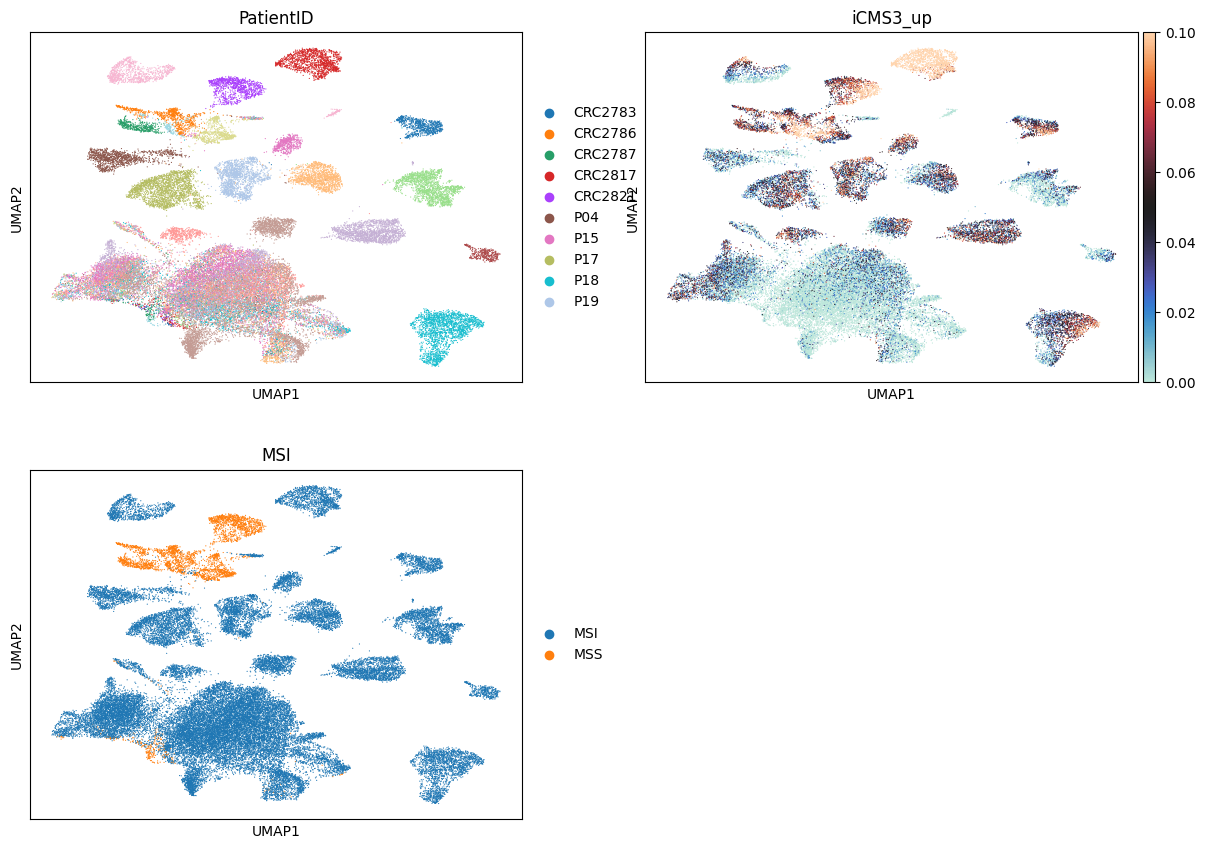

In [1078]:
sc.pl.umap(adata_concat, 
           color=['PatientID', 'iCMS3_up', 'MSI', ], vmin=0, vmax=0.1, cmap='icefire', ncols=2)

## Correlation between iCMS3 MSS vs. MSI-H vs. MSI-I vs. MSI-L

In [1193]:
set(adata_concat.obs['Manual_CellType_lvl_3'])

{'Enterocyte',
 'Enteroendocrine',
 'Goblet',
 'MSI-H CRC',
 'MSI-I CRC',
 'MSI-L CRC',
 'N/A',
 'Stem',
 'TA',
 'Tuft',
 'iCMS3 MSS CRC'}

In [1233]:
pdata = dc.get_pseudobulk(
    adata_concat[adata_concat.obs['Manual_CellType_lvl_3'].isin(['MSI-L CRC', 'MSI-I CRC', 'MSI-H CRC', 'iCMS3 MSS CRC'])],
    sample_col='Manual_CellType_lvl_3',
    groups_col='Manual_CellType_lvl_3',
    mode='mean',
    min_cells=0,
    min_counts=0
)

In [1112]:
import scipy.stats 

PearsonRResult(statistic=0.9598033901288509, pvalue=0.0)

In [1234]:
sc.pp.normalize_total(pdata)
sc.pp.log1p(pdata)

In [1210]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(pdata.X[0].reshape(1, -1), pdata.X[1].reshape(1, -1)).ravel()[0]

0.7432098

In [1216]:
scipy.stats.pearsonr(pdata.X[0], pdata.X[1])

PearsonRResult(statistic=0.918083924504144, pvalue=0.0)

In [1222]:
list(pdata.obs.index)

['Enterocyte',
 'Goblet',
 'MSI-H CRC',
 'MSI-I CRC',
 'MSI-L CRC',
 'Stem',
 'TA',
 'iCMS3 MSS CRC']

In [1230]:
from scipy.spatial.distance import jensenshannon

<Axes: >

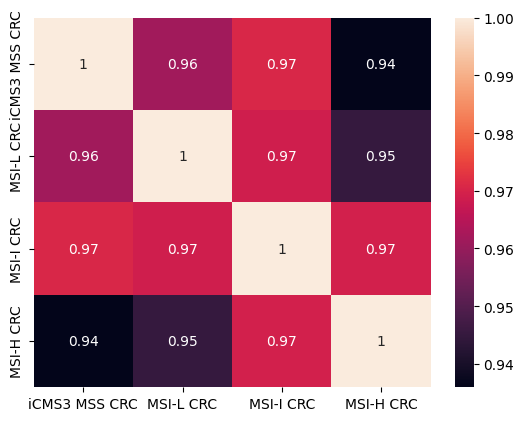

In [1281]:
confusion_mtx = list() 

for i in range(0, 3+1):
    temp = list()
    for j in range(0, 3+1):
        if i == j: 
            temp.append(1)            
        else:

            temp.append( scipy.stats.pearsonr(pdata.X[i], pdata.X[j])[0], )
            
            # p1 = pdata.X[i]
            # p2 = pdata.X[j]
            # p1 /= p1.sum()
            # p2 /= p2.sum()
            # jsd = jensenshannon(p1, p2)
            # temp.append( jsd )

            # temp.append( cosine_similarity(pdata.X[0].reshape(1, -1), pdata.X[1].reshape(1, -1)).ravel()[0] )
    confusion_mtx.append(temp)
    
confusion_mtx = pd.DataFrame(confusion_mtx)
confusion_mtx.index = list(pdata.obs.index)
confusion_mtx.columns = list(pdata.obs.index)

confusion_mtx = confusion_mtx.reindex(['iCMS3 MSS CRC', 'MSI-L CRC', 'MSI-I CRC', 'MSI-H CRC'],)
confusion_mtx = confusion_mtx[['iCMS3 MSS CRC', 'MSI-L CRC', 'MSI-I CRC', 'MSI-H CRC']]

sns.heatmap(confusion_mtx, 
            # vmin=0.84, vmax=1, 
            # cmap='vlag', 
            annot=True,)

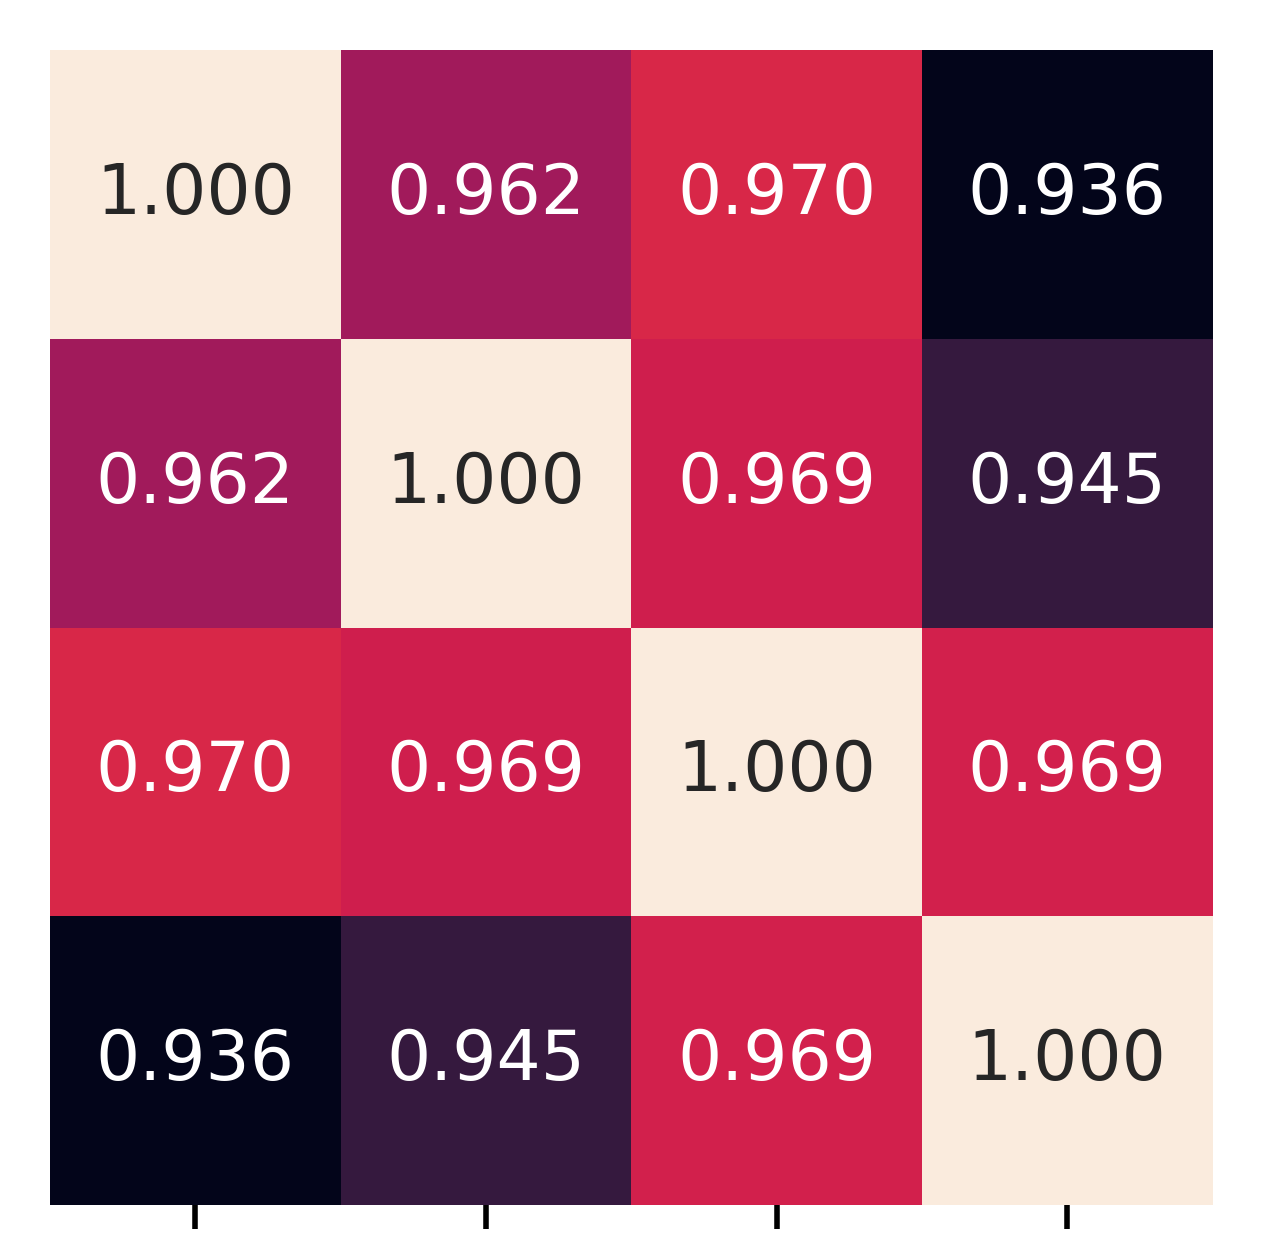

In [1284]:
plt.figure(figsize=(3, 3), dpi=500)
ax = sns.heatmap(confusion_mtx, 
            annot=True, fmt=".3f", 
            cbar=None,)
ax.set_xticklabels([]);
ax.set_yticklabels([]);
ax.set_yticks([]);

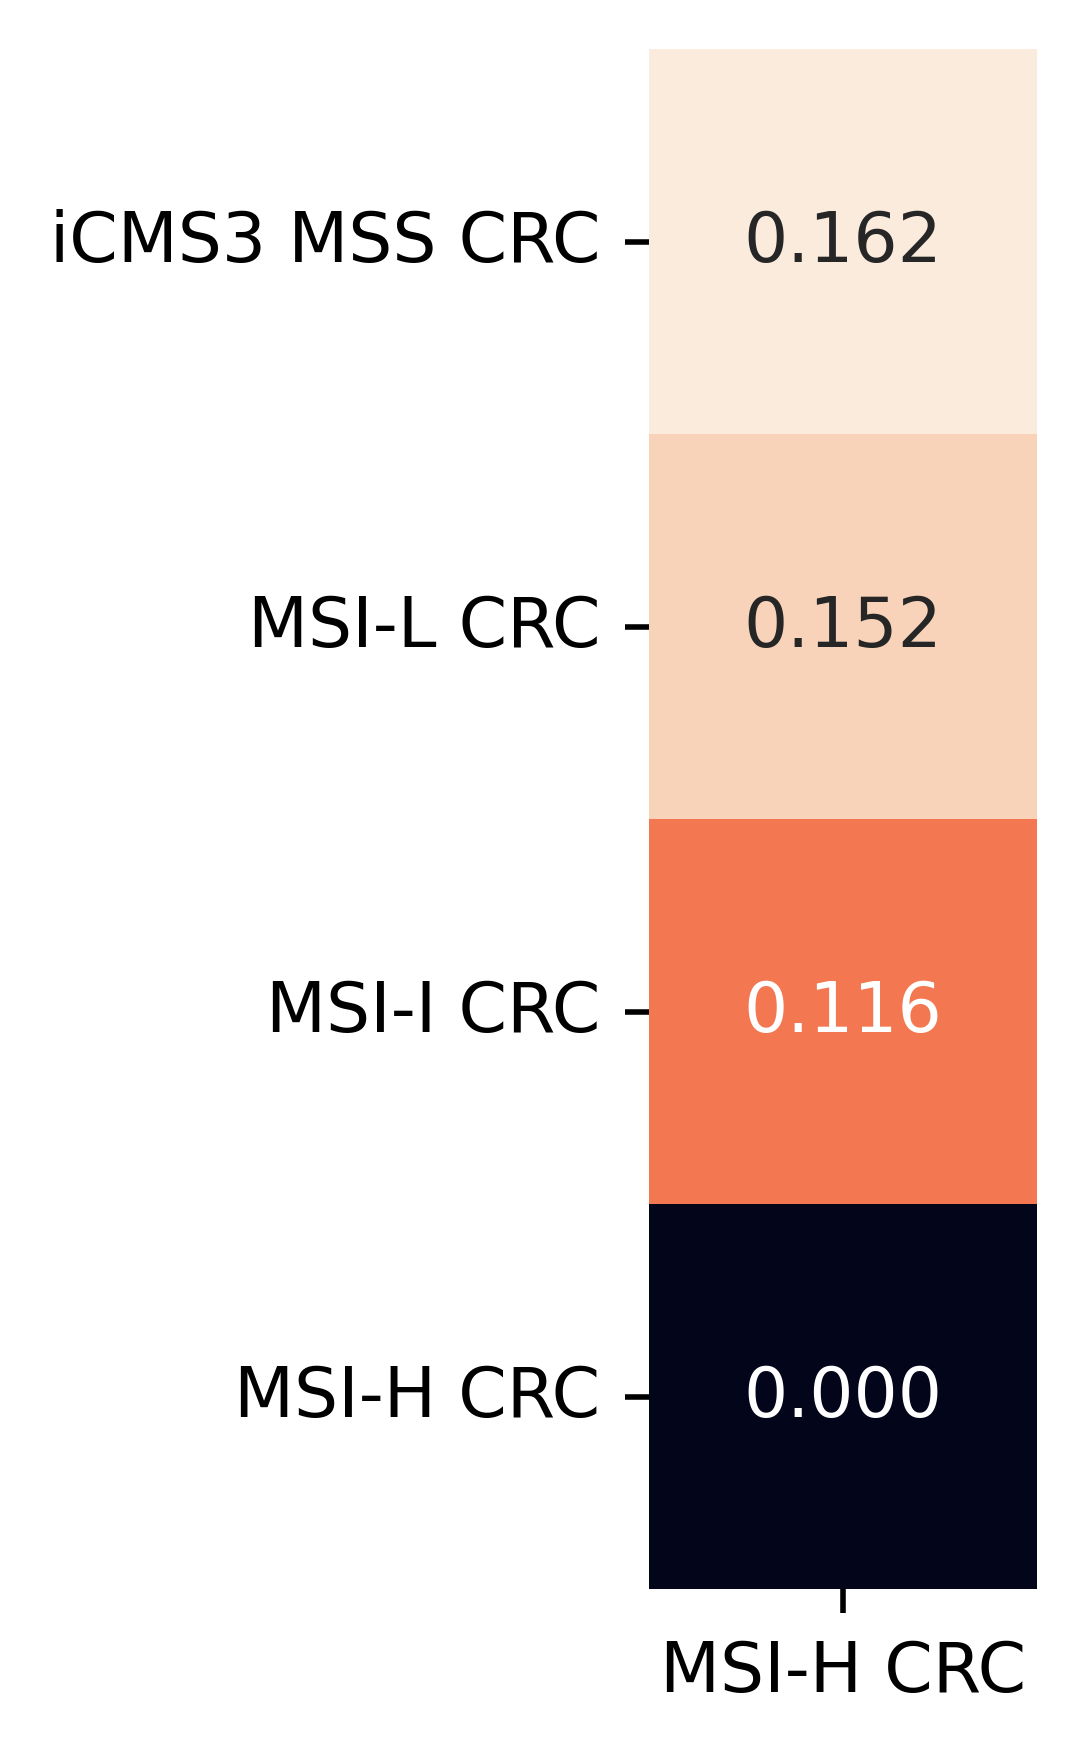

In [1275]:
plt.figure(figsize=(1, 4), dpi=500)
ax = sns.heatmap(confusion_mtx[['MSI-H CRC']], 
                 annot=True, fmt=".3f", 
                 cbar=None, )
# ax.set_yticklabels([]);
# ax.set_yticks([]);
# ax.set_xticklabels([]);

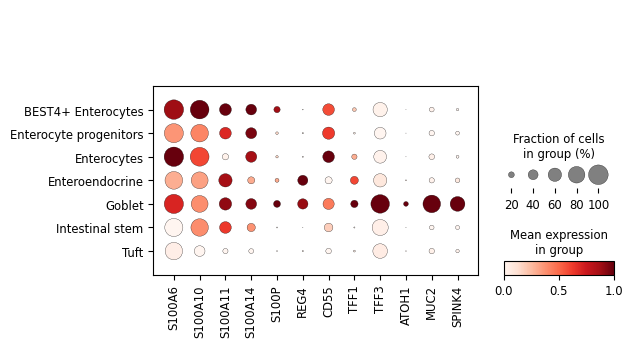

In [1634]:
MSI_H_GenesOfInterest = [ 'PIGR', 'PRUNE2', 'PIK3R3', 'RGMB', 'ASCL2', 'SOX4', 'NUPR1', 'PHGDH' ]
MSI_H_GenesOfInterest = [ 'S100A6', 'S100A10', 'S100A11', 'S100A14', 'S100P',
                         'REG4', 'CD55', 'TFF1', 'TFF3', 'ATOH1', 'MUC2', 'SPINK4',]

sc.pl.dotplot(adata_chen[(adata_chen.obs['Manual_CellType_lvl_1']=='Epithelial') & 
                         (adata_chen.obs['Manual_CellType_lvl_2']!='N/A')], groupby='Manual_CellType_lvl_2', var_names=MSI_H_GenesOfInterest, standard_scale='var',)

## TissueEnrich

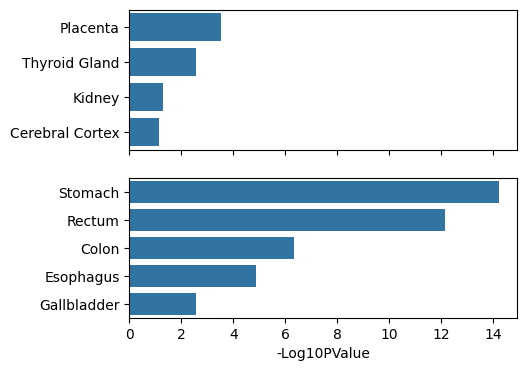

In [348]:
TissueEnrich_up = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/CRC_MSI_intensity_analysis/TissueEnrich/IntersectingUp.tsv', sep='\t')
TissueEnrich_dw = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/CRC_MSI_intensity_analysis/TissueEnrich/IntersectingDown.tsv', sep='\t')

TissueEnrich_up = TissueEnrich_up[TissueEnrich_up['-Log10PValue']>=1]
TissueEnrich_dw = TissueEnrich_dw[TissueEnrich_dw['-Log10PValue']>=1]

fig, axes = plt.subplots(2, 1, figsize=(5, 4), sharex=True)
ax = sns.barplot(data=TissueEnrich_up.head(5), y='Tissue', x='-Log10PValue', ax=axes[0])
ax.set_ylabel('');
ax = sns.barplot(data=TissueEnrich_dw.head(5), y='Tissue', x='-Log10PValue', ax=axes[1])
ax.set_ylabel('');

## SC035 Tumor subclusters

In [3]:
adata_SC035 = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.preprocessed.NanoMnT.ManualAnnot.SC035.h5ad')

In [4]:
# adata_epi_tumor_SC035 = adata_epi[(adata_epi.obs['PatientID']=='SC035') & (adata_epi.obs['Manual_CellType_lvl_1']=='Tumor epithelial')].copy()
adata_epi_tumor_SC035 = adata_SC035[(adata_SC035.obs['Manual_CellType_lvl_1']=='Tumor epithelial')].copy()
adata_epi_tumor_SC035 = adata_epi_tumor_SC035.raw.to_adata()

sc.pp.normalize_total(adata_epi_tumor_SC035)
sc.pp.log1p(adata_epi_tumor_SC035)
sc.pp.highly_variable_genes(adata_epi_tumor_SC035, n_top_genes=2000, batch_key="SampleID")

adata_epi_tumor_SC035.raw = adata_epi_tumor_SC035.copy()
adata_epi_tumor_SC035 = adata_epi_tumor_SC035[:, adata_epi_tumor_SC035.var.highly_variable]

sc.pp.scale(adata_epi_tumor_SC035, max_value=10)
sc.tl.pca(adata_epi_tumor_SC035, svd_solver="arpack")

sc.pp.neighbors(adata_epi_tumor_SC035, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_epi_tumor_SC035, random_state=0)

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
2025-03-11 10:28:53.854734: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-11 10:28:53.856130: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-11 10:28:53.909359: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-11 10:28:53.922240: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-11 

In [ ]:
sc.tl.score_genes(adata_epi_tumor_SC035, intersecting_up,   score_name='intersecting_up')
sc.tl.score_genes(adata_epi_tumor_SC035, intersecting_down, score_name='intersecting_dw')

with plt.rc_context({"figure.dpi": (500), 'figure.figsize':(5, 2.5)},):
    ax = sc.pl.violin(adata_epi_tumor_SC035, keys=['intersecting_up'], groupby='SComatic_CellType', order=['Tumor_1', 'Tumor_0', 'Tumor_2'], show=False)
    ax.set_xlabel('');
    ax.set_ylabel('');
    ax.set_xticklabels([]);
    # ax.set_yticklabels([]);
with plt.rc_context({"figure.dpi": (500), 'figure.figsize':(5, 2.5)},):
    ax = sc.pl.violin(adata_epi_tumor_SC035, keys=['intersecting_dw'], groupby='SComatic_CellType', order=['Tumor_1', 'Tumor_0', 'Tumor_2'], show=False)
    ax.set_xlabel('');
    ax.set_ylabel('');
    ax.set_xticklabels([]);
    # ax.set_yticklabels([]);

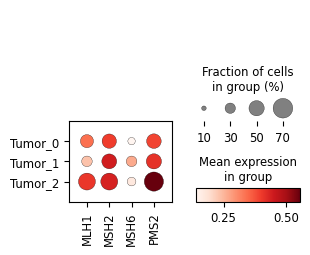

In [7]:
sc.pl.dotplot(adata_epi_tumor_SC035, var_names=['MLH1', 'MSH2', 'MSH6', 'PMS2'], groupby='SComatic_CellType',)